# Setup

In [1]:
%matplotlib inline
import numpy as np
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt

import os
import neo.io
import elephant

# SETPARAM: uncomment if DEBUG
# %load_ext autoreload
# %autoreload 2

# analysis.py module in same folder
from bgcellmodels.common import units, analysis, signal as ephys_algos
from bgcellmodels.extensions.neo import signal as neoutil

units.set_units_module('quantities')
import quantities as pq

# Jupyter notebook extensions
%load_ext bgcellmodels.extensions.jupyter.skip_cell_extension

Using units module 'quantities'


## Plotting Options

In [2]:
# Figure dimensions
fig_aspect_ratio = 8.0 / 3.0
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception() # fix bug for notebook backend where figures not shown
    page_width = 10
else:
    page_width = 10

fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio
ax_width = 0.7 * page_width
ax_height = ax_width / fig_aspect_ratio

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

## Support Functions

In [3]:
def make_slice(interval, t_start, Ts):
    """
    Make slice object for addressing interval (a,b) in signal starting
    at t_start and recorded with sampling time Ts.
    """
    irange = [int((t-tstart)/Ts) for t in interval]
    return np.s_[irange[0]:irange[1]] # slice object

# Import Data

## Import Settings

Define settings here or load from external python script by uncommenting second cell.

In [4]:
# All variables defined in this cell can be overridden from settings file
outputs = '/home/luye/Documents/sim_data/LuNetDBS/LuNetStnGpe_2019.05.17_13.45.08_job-1282733.sonic-head_test_dbs_silent_dbs-amp-5'
# SETPARAM: choose time segment to load if split over files
matfile_common_pattern = '-1500ms'

# SETPARAM: region of interest (ROI) for plotting
ROI_INTERVAL = (0.0, 1000.0)

# SETPARAM: reference phase 'from_ctx' / 'from_stn' / 'from_gpe' / float
reference_phase = {
    'method': 'from_gpe',
    'passband': (25.0, 32.0)
}

sweep_var_name = 'gmax_ctx_stn'
sweep_var_value = '1.20'
automatic_execution = False

# SETPARAM: filename for numerical analysis results (pickle file)
outsuffix = '{:.1f}s-{:.1f}s'.format(ROI_INTERVAL[0]/1e3, ROI_INTERVAL[1]/1e3)
pickle_filename = 'analysis_results_{}_ARTICLE.pkl'.format(outsuffix)

In [5]:
# SETPARAM: uncomment cell if settings from external configuration file
# conf_file = os.environ.get('NB_CONF_FILE', 'nb_exec_conf.py') # pass filename from calling script
# with open(conf_file) as conf:
#     conf_script = conf.read()
#     print("Contents of config file:\n" + conf_script)

# SETPARAM: as alternative, paste configuration file as text
# conf_script = """<paste here>"""

# Execute configuration script to load settings variables
# exec(conf_script)

In [6]:
# SETPARAM: directory to save figures, set to None for no saving
parent_dir, _ = os.path.split(outputs)
save_fig_path = os.path.join(parent_dir, 'figures_network_analysis_fig3b') # None

# SETPARAM: whether to save figures
export_figs = False
if export_figs and not os.path.exists(save_fig_path):
    os.mkdir(save_fig_path)

def save_figure(fname, fig=None, **kwargs):
    """
    Save given or current figure.
    For LaTeX embedding, use extension pdf/pgf/eps in the figure name.
    
    kwargs: see https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html
    """
    kwargs.setdefault('bbox_inches', 'tight') # prevents cropping
    kwargs.setdefault('transparent', True) # transparent background, see also 'frameon'
    fname += '_sweep-val-{}'.format(sweep_var_value)
    fname += '.' + kwargs.setdefault('format', 'pdf')
    fig_filepath = os.path.join(save_fig_path, fname)
    if fig is None:
        plt.savefig(fig_filepath, **kwargs) # save current figure
    else:
        fig.savefig(fig_filepath, **kwargs) # save specific figure
    print("Figure saved to file {}".format(fig_filepath))
    return fig_filepath

def offset_show_twin_yax(ax, offset=1.2):
    """
    Having been created by twinx, ax has its frame off, so the line of its
    detached spine is invisible.  First, activate the frame but make the patch
    and spines invisible. Then make the detached spine visible.
    """
    ax.spines["right"].set_position(("axes", offset))
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.spines["right"].set_visible(True)

def hide_axis(ax):
    ax.set_frame_on(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Export Settings

In [7]:
# Save all PSDs for comparison in figures
all_psd = {}          # tuple[list[float]: freqs, list[float]: psd)
all_psd_peaks = {}    # tuple[list[float]: peak_freqs, list[float] : peak_psd)
all_psd_sum_subband = {} # tuple[list[tuple[int,int]]: band_limits, float: sum_psd)
all_fpeak = {}        # tuple[list[float]: freqs, list[float]: psd)

all_signals = {}   # neo.AnalogSignal variables
all_vm_signals = {}
all_mean_rate = {}
all_morgera = {}
all_spectrogram = {}
all_sigmean = {}
all_burst_metrics = {}
all_comp_coherence = {} # dict['<pop A>-<pop B>', (fs: numpy.array, Cxy:numpy.array)]
all_vmean_coherence = {}
all_I_exc_inh = {}
all_I_afferents = {}

# SETPARAM: data that will be exported (choose dicts above)
exported_data = {
    'mean_rate': all_mean_rate,
    'PSD': all_psd,
#     'PSD_peaks': all_psd_peaks,
#     'PSD_subband_power': all_psd_sum_subband,
#     'PSD_input_freq': all_fpeak,
    'spectrogram': all_spectrogram,
    'Morgera_index': all_morgera,
    'burst_metrics': all_burst_metrics,
    'coherence_vmean': all_vmean_coherence,
    'coherence_composite': all_comp_coherence,
    'I_exc_inh_ratio': all_I_exc_inh,
    'I_afferents' : all_I_afferents,
    # Metadata
    'sim_config': None,
    'sweep_settings': {'var_name': sweep_var_name, 'var_value': sweep_var_value},
    'analyzed_interval': ROI_INTERVAL,
    'populations': None,
}

all_cell_phase_vecs = exported_data.setdefault('cell_phase_vecs', {})
all_pop_phase_vecs = exported_data.setdefault('pop_phase_vecs', {})

## Load Data

In [8]:
# File filter for Neo data files
file_filter = lambda f: f.endswith('.mat') and matfile_common_pattern in f

if isinstance(outputs, str):
    filenames = os.listdir(outputs)
    pop_files = [os.path.join(outputs, f) for f in filenames if file_filter(f)]
    params_file = next((os.path.join(outputs,f) for f in filenames if f.startswith('pop-parameters')), None)
else:
    # outputs is list[str] of paths to .mat files
    pop_files = outputs
    params_file = None

pops_segments = {}
read_segment_id = 0

# Read binary files using Neo IO module
for pop_file in pop_files:
    reader = neo.io.get_io(pop_file)
    blocks = reader.read()
    assert len(blocks) == 1, "More than one Neo Block in file."
    pop_label = blocks[0].name

    if len(blocks[0].segments)-1 < read_segment_id:
        raise ValueError("Segment index greater than number of Neo segments"
                         " in file {}".format(pop_file))
    if pop_label in pops_segments:
        raise ValueError("Duplicate population labels in files")
        
    pops_segments[pop_label] = blocks[0].segments[read_segment_id]

# Extract some signal metadata
exported_data['populations'] = pop_labels = pops_segments.keys()
sim_dur = pops_segments['STN'].spiketrains[0].t_stop.magnitude

# Make all spike trains accessible by population
def spiketrains_by_gid(gids, pop_filter=None):
    if pop_filter is None:
        filter_func = lambda p: True
    elif isinstance(pop_filter, str):
        filter_func = lambda p: p.startswith(pop_filter)
    all_trains = sum([seg.spiketrains for pop, seg in pops_segments.items() if filter_func(pop)], [])
    return [st for st in all_trains if st.annotations['source_id'] in gids]

In [9]:
# Load the simulation config file
from bgcellmodels.common import fileutils
exported_data['sim_config'] = sim_config = fileutils.parse_json_file(
    os.path.join(outputs, 'simconfig', 'sim_config.json'), nonstrict=True)

# Check if segment contains bursting inputs
ctx_bursting_frac = sim_config['CTX']['spiking_pattern']['bursting_fraction']
ctx_burst_intervals = sim_config['CTX']['spiking_pattern']['intervals']
without_ctx_bursting = (
    (ctx_bursting_frac == 0)
    or all((ival[1] <= ROI_INTERVAL[0] for ival in ctx_burst_intervals))
    or all((ival[0] >= ROI_INTERVAL[1] for ival in ctx_burst_intervals))
)

In [10]:
# The recordings are saved in Neo format. See:
# http://neo.readthedocs.io/en/latest/
# http://neo.readthedocs.io/en/latest/api_reference.html#neo.core.AnalogSignal
# - Each segment has attributes 'analogsignals' and 'spiketrains'
# - Each quantity (e.g. AnalogSignal.signal) has attributes magnitude, units, dimensionality

# List all recorded signals
for pop_label, segment in pops_segments.items():
    print("\n{} has following signals:".format(pop_label))
    for signal in segment.analogsignals:
        print("\t- '{:10}\t[{}] - description: {}".format(signal.name, signal.units, signal.description))
    print("\t- {} spiketrains".format(len(segment.spiketrains)))


STN has following signals:
	- 'Vm        	[1.0] - description: None
	- 'lfp       	[1.0] - description: None
	- 'gGABAA0   	[1.0] - description: None
	- 'gGABAA2   	[1.0] - description: None
	- 'i_GLU11   	[1.0] - description: None
	- 'g_AMPA1   	[1.0] - description: None
	- 'gGABAA1   	[1.0] - description: None
	- 'i_NR2A10  	[1.0] - description: None
	- 'i_NR2A11  	[1.0] - description: None
	- 'i_NR2A12  	[1.0] - description: None
	- 'i_NR2A13  	[1.0] - description: None
	- 'i_NR2A6   	[1.0] - description: None
	- 'i_NR2A7   	[1.0] - description: None
	- 'i_NR2A4   	[1.0] - description: None
	- 'STN_CaL_inact	[1.0] - description: None
	- 'i_NR2A2   	[1.0] - description: None
	- 'i_NR2A0   	[1.0] - description: None
	- 'i_NR2A1   	[1.0] - description: None
	- 'i_NR2A8   	[1.0] - description: None
	- 'i_GLU0    	[1.0] - description: None
	- 'i_GLU1    	[1.0] - description: None
	- 'i_GLU2    	[1.0] - description: None
	- 'i_GLU3    	[1.0] - description: None
	- 'i_GLU4    	[1.0] - des

# Network Parameters

In [11]:
if params_file is not None:
    import pickle
    with open(params_file, 'rb') as pf:
        network_params = pickle.load(pf)
        print("Found parameters for following populations:\n"
              "{}\n".format(network_params.keys()))

    for pre_pop, pre_params in network_params.iteritems():
        if not isinstance(pre_params, dict):
            print("Ignoring entry: '{}'\n".format(pre_pop))
            continue
        for post_pop, pre_post_params in pre_params.iteritems():
            if 'conpair_pvals' in pre_post_params:
                print("Parameters for connection {} -> {}:\n"
                      "{}\n{}\n".format(pre_pop, post_pop,
                                        pre_post_params['conpair_pnames'], 
                                        pre_post_params['conpair_pvals'][:,2:].max(axis=0)))

Found parameters for following populations:
['GPE.axons', 'STN', 'CTX', 'dopamine_depleted', 'STR.MSN', 'GPE.surrogate', 'GPE.all', 'GPE.proto', 'STN.surrogate', 'CTX.axons']

Parameters for connection GPE.axons -> STN:
['delay', 'weight', 'gmax_GABAA', 'gmax_GABAB']
[2.        0.        0.018     0.0037485]

Parameters for connection STN -> GPE.proto:
['delay', 'weight', 'gmax_AMPA', 'gmax_NMDA']
[2.00e+00 0.00e+00 3.75e-04 0.00e+00]

Parameters for connection CTX -> CTX.axons:
['delay', 'weight']
[0.1 0. ]

Ignoring entry: 'dopamine_depleted'

Parameters for connection STR.MSN -> GPE.proto:
['delay', 'weight', 'gmax_GABAA']
[5.e+00 0.e+00 3.e-04]

Parameters for connection GPE.all -> GPE.proto:
['delay', 'weight', 'gmax_GABAA', 'gmax_GABAB']
[5.e-01 0.e+00 2.e-04 4.e-05]

Parameters for connection GPE.all -> GPE.axons:
['delay', 'weight']
[0.1 0. ]

Parameters for connection CTX.axons -> STN:
['delay', 'weight']
[5.9 0. ]



/home/luye/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  del sys.path[0]


## Connection Matrices

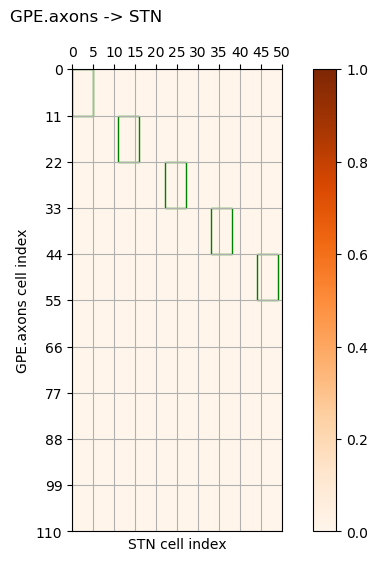

/home/luye/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


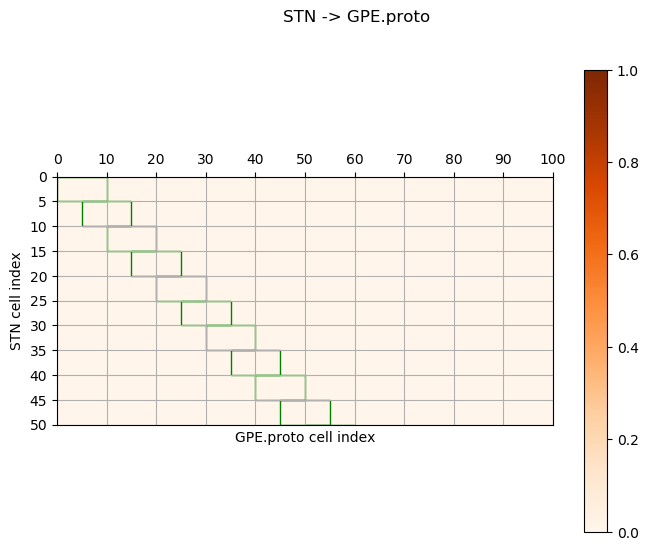

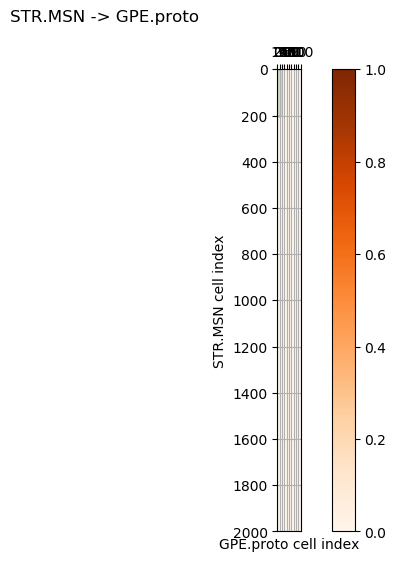

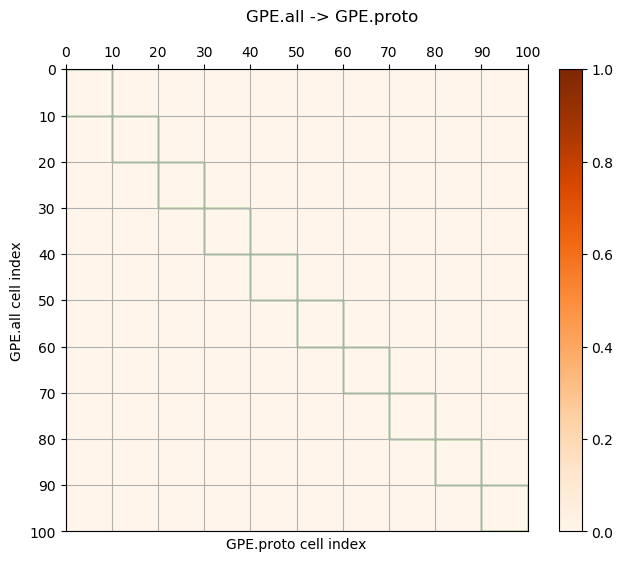

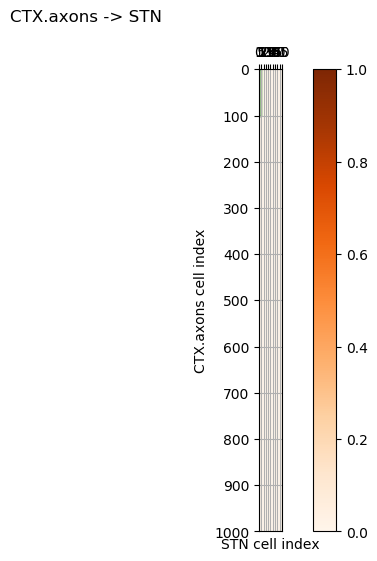

In [12]:
from bgcellmodels.common import analysis

# Print STN-GPE connection matrix
skip_targets = 'GPE.axons', 'CTX.axons'
for pre_pop, pre_params in network_params.iteritems():
    if not isinstance(pre_params, dict):
        continue
    for post_pop, pre_post_params in pre_params.iteritems():
        if post_pop in skip_targets:
            continue
        if 'conn_matrix' in pre_post_params:
            adjacency_mat = pre_post_params['conn_matrix']
            divx = max(3, adjacency_mat.shape[1]/10)
            divy = max(3, adjacency_mat.shape[0]/10)
            analysis.plot_connectivity_matrix(adjacency_mat, 
                                              pop0=pre_pop, pop1=post_pop,
                                              px=divx, py=divy,
                                              title='{} -> {}'.format(pre_pop, post_pop))

# for pops in [('STN', 'GPE'), ('GPE', 'STN'), ('GPE', 'GPE'), ('STN', 'STN')]:
#     stn_gpe_weights = network_params[pops[0]][pops[1]]['conn_matrix']
#     analysis.plot_connectivity_matrix(stn_gpe_weights, pop0=pops[0], pop1=pops[1], pop_size=100, seaborn=False)

# Spike Trains

<span style='color:red;font-weight:bold'>WARNING</SPAN>: In rastergram plots, note the number of spike trains plotted (see y-axis). If it is too high you get overlapping marker bars (marker height is larger than row height allocated to one spiketrain). This leads to misleading plots as spiketrains are overlapping which looks like an artificially elevated firing rate.

In [13]:
line_colors = 'crkgbm'
pop_color_map = {k: line_colors[i % len(line_colors)] for i,k in enumerate(sorted(pops_segments.keys()))}

def get_pop_color(pop_label):
    return pop_color_map[pop_label]

def get_pop_order(pop_label):
    if pop_label.startswith('CTX'):
        return 0
    elif pop_label.startswith('STR'):
        return 1
    elif pop_label.startswith('GPE'):
        return 2
    elif pop_label.startswith('STN'):
        return 3
    else:
        return 100

## Spike Statistics

In [14]:
import collections
pop_firing_rates = collections.OrderedDict()
for pop_label in sorted(pops_segments.keys(), key=get_pop_order):
    segment = pops_segments[pop_label]
    # Can use elephant.spike_train_generation.peak_detection() if only raw voltage signals
    pop_rate = 0.0
    for st in segment.spiketrains:
        pop_rate += elephant.statistics.mean_firing_rate(st).rescale('Hz').magnitude
    pop_rate = pop_rate / len(segment.spiketrains)
    pop_firing_rates[pop_label] = pop_rate
    
    all_mean_rate[pop_label] = pop_rate
    print("Mean firing rate for {} is {}".format(pop_label, pop_rate))

Mean firing rate for CTX is 8.95533333328
Mean firing rate for CTX.axons is 86.6666666661
Mean firing rate for STR.MSN is 7.02866666662
Mean firing rate for GPE.surrogate is 14.8666666666
Mean firing rate for GPE.axons is 0.0
Mean firing rate for GPE.proto is 0.0
Mean firing rate for STN is 8.42666666661
Mean firing rate for STN.surrogate is 28.7999999998


(0.0, 1.0, 0.0, 1.0)

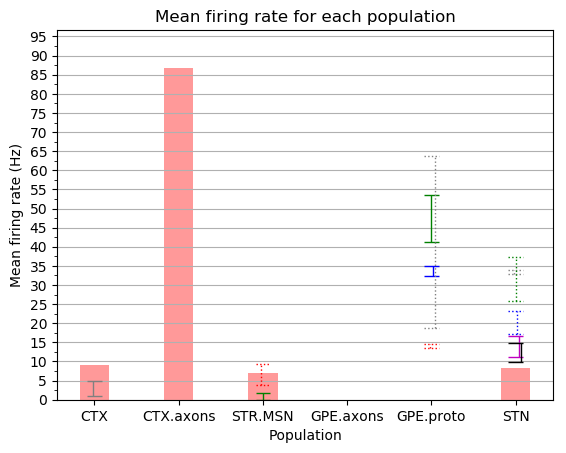

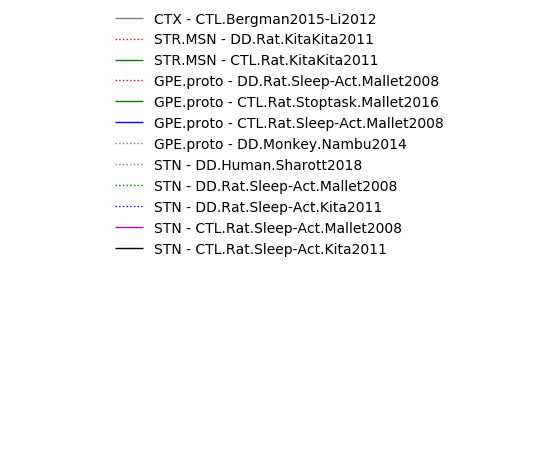

In [15]:

# Also plot target rates in DD and normal conditions
invivo_rates = { # (upper, lower) or (median-std, median+std)
    'CTX': {
        'CTL.Bergman2015-Li2012': [1.0, 5.0],
    },
    'STR.MSN': {
        'DD.Rat.KitaKita2011': [3.8, 9.4], # Kita & Kita (2011): baseline, peak is 140
        'CTL.Rat.KitaKita2011': [0.0, 1.65], # Kita Kita (2011)
    },
    'STR.FSI': {
        'CTL.Berke2004': [10.0, 100.0], # Berke (2004, 2008)
    },
    'GPE.proto': {
        'DD.Monkey.Nambu2014': [18.7, 63.7], # Nambu (2014): mean 41.2
        'CTL.Rat.Stoptask.Mallet2016': [41.3, 53.5],
        'CTL.Rat.Sleep-Act.Mallet2008': [32.4, 35.0],
        'DD.Rat.Sleep-Act.Mallet2008': [13.6, 14.6],
        # Nambu(2014): mean 65.2
    },
    'GPE.arky': {
        'CTL.Rat.Mallet2016': [7.0, 10.8], # rat, Mallet (2016)
    },
    'STN': {
        # 'CTL.Monkey.Bergman2015': [20.0, 25.0], # Bergman book
        'CTL.Rat.Sleep-Act.Mallet2008': [11.1, 16.6],
        'DD.Rat.Sleep-Act.Mallet2008': [25.8, 37.4],
        'CTL.Rat.Sleep-Act.Kita2011': [9.8, 14.8],
        'DD.Rat.Sleep-Act.Kita2011': [17.3, 23.3],
        'DD.Human.Sharott2018': [33.0, 34.0],
    }
}

fig, ax = plt.subplots()

model_pops = [k for k in pop_firing_rates.keys() if 'surrogate' not in k]
index = np.arange(len(model_pops))
bar_width = 0.35
opacity = 0.4

rate_indicators = []
rate_labels = []
for i, pop_label in enumerate(model_pops):
    # Draw in vivo rates
    for j, src_rates in enumerate(invivo_rates.get(pop_label, {}).items()):
        label, bounds = src_rates
        color = 'rgbmk'[j] if 'Rat' in label else 'grey' 
        line_kwargs = {'color': color, 'linewidth': 1.0, 'linestyle': ':' if label.startswith('DD') else '-'}
        lines = ax.vlines(i-.02+j*.02, bounds[0], bounds[1], **line_kwargs)
        ax.hlines(bounds, i-bar_width/4, i+bar_width/4, **line_kwargs)
        rate_indicators.append(lines)
        rate_labels.append('{} - {}'.format(pop_label, label))
    
    # Draw simulation rates
    pop_rate = pop_firing_rates[pop_label]
    color = 'green' if (bounds[0] <= pop_rate <= bounds[1]) else 'red' # red bar if not within in-vivo range
    ax.bar(i, pop_rate, bar_width, alpha=opacity, color=color)


ax.set_xlabel('Population')
ax.set_ylabel('Mean firing rate (Hz)')
ax.set_title('Mean firing rate for each population')
ax.set_xticks(index)
ax.set_xticklabels(model_pops)
max_rate = max(pop_firing_rates.values())+10
ax.set_yticks(np.arange(0, max_rate+5, 5), minor=False)
ax.set_yticks(np.arange(0, max_rate+2.5, 2.5), minor=True)
ax.set_ylim((0, max_rate))
ax.grid(True, axis='y', which='major')
# ax.legend()

# Draw separate legend
fig, ax = plt.subplots()
fig.legend(rate_indicators, rate_labels, loc='upper center', frameon=False)
ax.axis('off')

## Running Spikerates

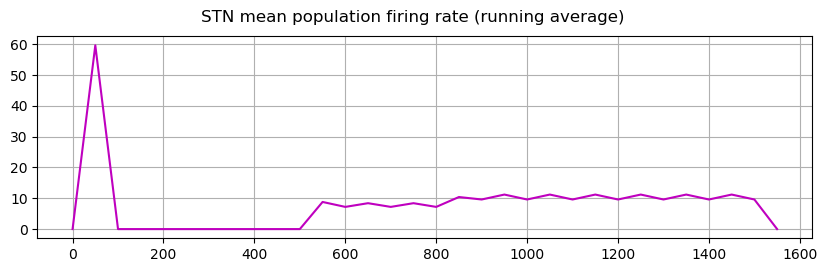

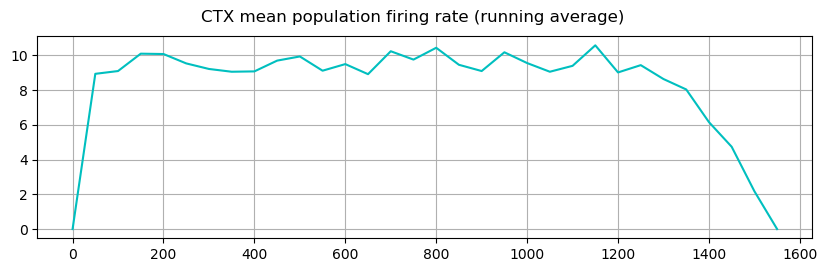

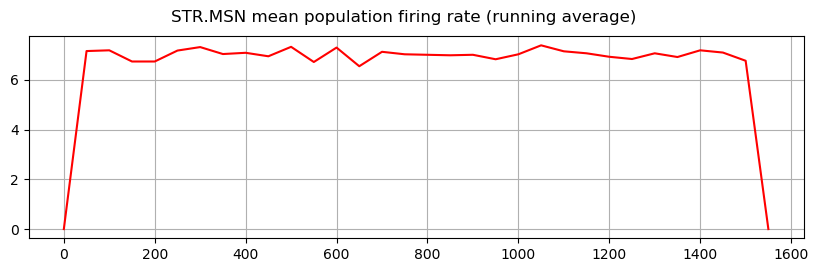

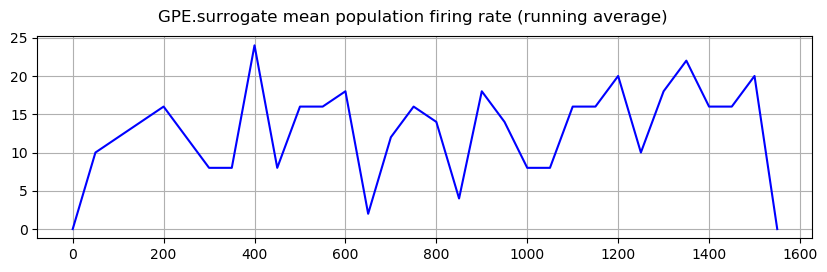

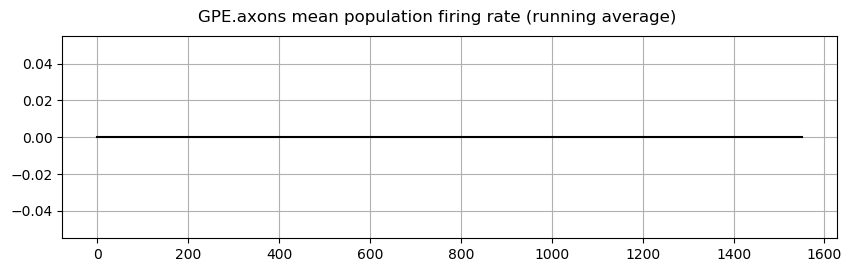

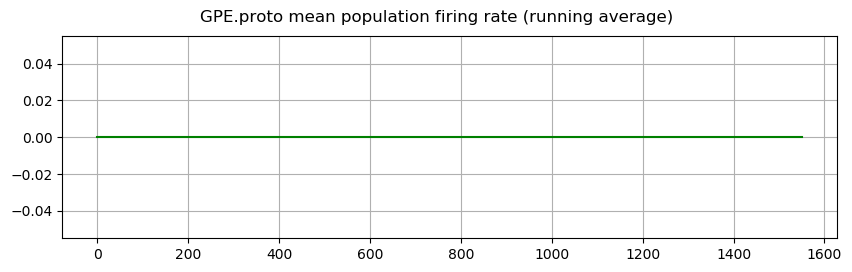

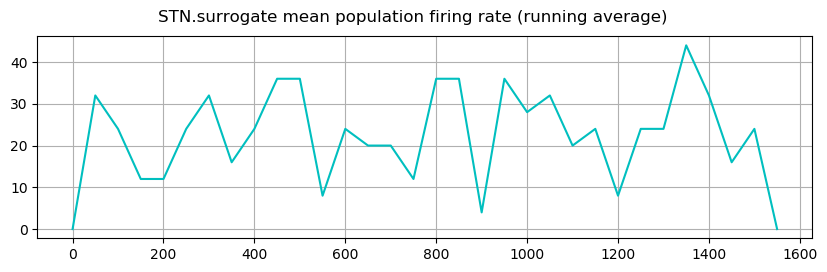

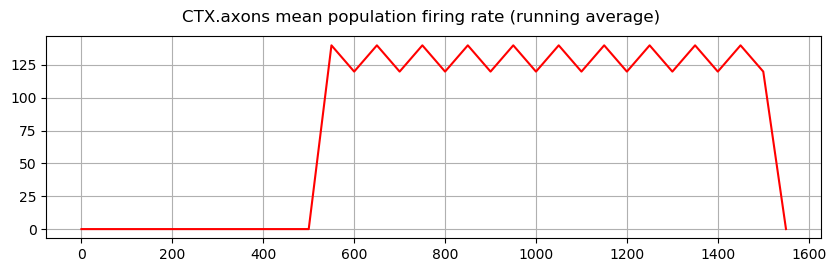

In [16]:
# %%skip False

def plot_avg_spikerate(pop_label, cell_ids=None, t_range=None, bin_width=20.0, adaptive=False, fig=None):
    """
    Plot running mean firing rate of population.
    Bin width also determines bin spacing (no sliding window).
    """
    segment = pops_segments[pop_label]
    if cell_ids is None:
        cell_ids = range(len(segment.spiketrains))
    if t_range is None:
        t_range = (0.0, np.round(segment.spiketrains[0].t_stop.magnitude, 3))
    
    min_spikes = 10
    # Adaptive method increases bin adaptively until 'min_spikes' included
    if adaptive:
        mean_rates = ephys_algos.nrn_avg_rate_adaptive([segment.spiketrains[i] for i in cell_ids],
                                                      t_range[0], t_range[1], binwidth=bin_width,
                                                      minsum=min_spikes).as_numpy()
    else:
        mean_rates = ephys_algos.nrn_avg_rate_simple([segment.spiketrains[i] for i in cell_ids],
                                                    t_range[0], t_range[1],
                                                    binwidth=bin_width).as_numpy()
    if fig is None:
        fig, ax = plt.subplots(1, 1, figsize=(page_width,ax_height))
    else:
        nrows = len(fig.axes)+1
        ax = fig.add_subplot(nrows,1,nrows)
        
    t_axis = np.arange(mean_rates.size) * bin_width + t_range[0]
    ax.plot(t_axis, mean_rates, color=get_pop_color(pop_label))
    ax.grid(True)
    
    fig.suptitle('{} mean population firing rate (running average)'.format(pop_label))
    return fig, ax

for pop in pop_labels:
    plot_avg_spikerate(pop, bin_width=50)
#fig.tight_layout()

## Raster Plots

In [17]:
num_pops = len(pops_segments)
i_pop = 0

def plot_spiketrain(pop_label, cell_ids, t_range, sharex=None, sharey=None,
                    figsize=(page_width,ax_height), plot_compact=False,
                    export=False, order_by='cell_pop_idx', ticks_dx=1e3,
                    grid=True):
    """
    Plot spiketrains for one population.
    
    @param    cell_ids : list(int)
              Cell indices in population that will be visible (y-axis constrainment).
    """
    global i_pop
    
    segment = pops_segments[pop_label]
    sim_dur = segment.spiketrains[0].t_stop.magnitude
    
    # Don't plot all rastergrams in same figure
    fig_spikes = plt.figure(figsize=figsize)
    ax = plt.subplot(1,1,1, sharex=sharex, sharey=sharey)
    # fig_spikes, ax = plt.subplot(1, 1, figsize=(page_width,ax_height), sharex=sharex)
    if not plot_compact:
        fig_spikes.suptitle('{} spiketrains'.format(pop_label))
    
    pop_size = len(segment.spiketrains)
    
    # Plot all spiketrains but constrain y-axis later (so you can pan & zoom)
    # for i_train in range(pop_size):
    #     y = spiketrain.annotations.get('source_id', i_train)
    # Only plot selected spike trains
    y_vals = np.empty(len(cell_ids))
    for j, i_train in enumerate(cell_ids):
        spiketrain = segment.spiketrains[i_train]
        if order_by == 'cell_pop_idx':
            y_vals[j] = i_train
        elif order_by == 'caller':
            y_vals[j] = j
        y_vec = np.ones_like(spiketrain) * y_vals[j]
        ax.plot(spiketrain, y_vec,
                marker='|', linestyle='', 
                snap=True, color=get_pop_color(pop_label))
    
    
    # ax.set_xticks(np.arange(0, sim_dur+5000, 5000), minor=False) # uncomment for long time range
    if plot_compact:
        ax.set_yticks([]) # (np.arange(min(y_vals), max(y_vals)+1, 1), minor=False)
        ax.set_xticks(np.arange(0, sim_dur+1000, ticks_dx), minor=False)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_yticks(np.arange(min(y_vals), max(y_vals)+5, 5), minor=False)
        ax.set_xticks(np.arange(0, sim_dur+1000, ticks_dx), minor=False)
        ax.set_ylabel('{} cell #'.format(pop_label))
        
    ax.set_xlim(t_range)
    ax.set_ylim((min(y_vals)-0.5, max(y_vals)+0.5))
    ax.grid(grid, axis='x', which='major')
    
    if export_figs and export:
        fname = 'rastergram_{}_cell-{}-{}'.format(pop_label, cell_ids[0], cell_ids[-1])
        save_figure(fname, fig=fig_spikes, bbox_inches='tight')

    i_pop += 1
    return fig_spikes, ax

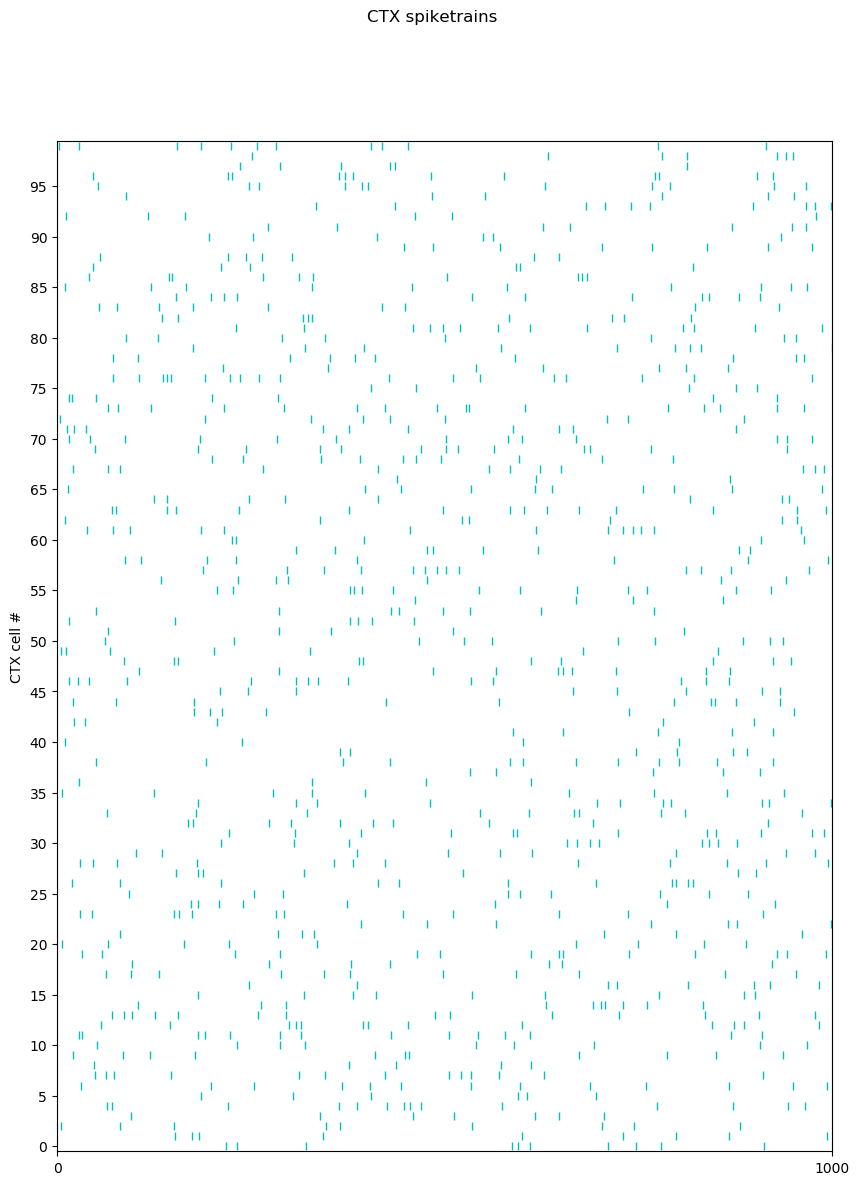

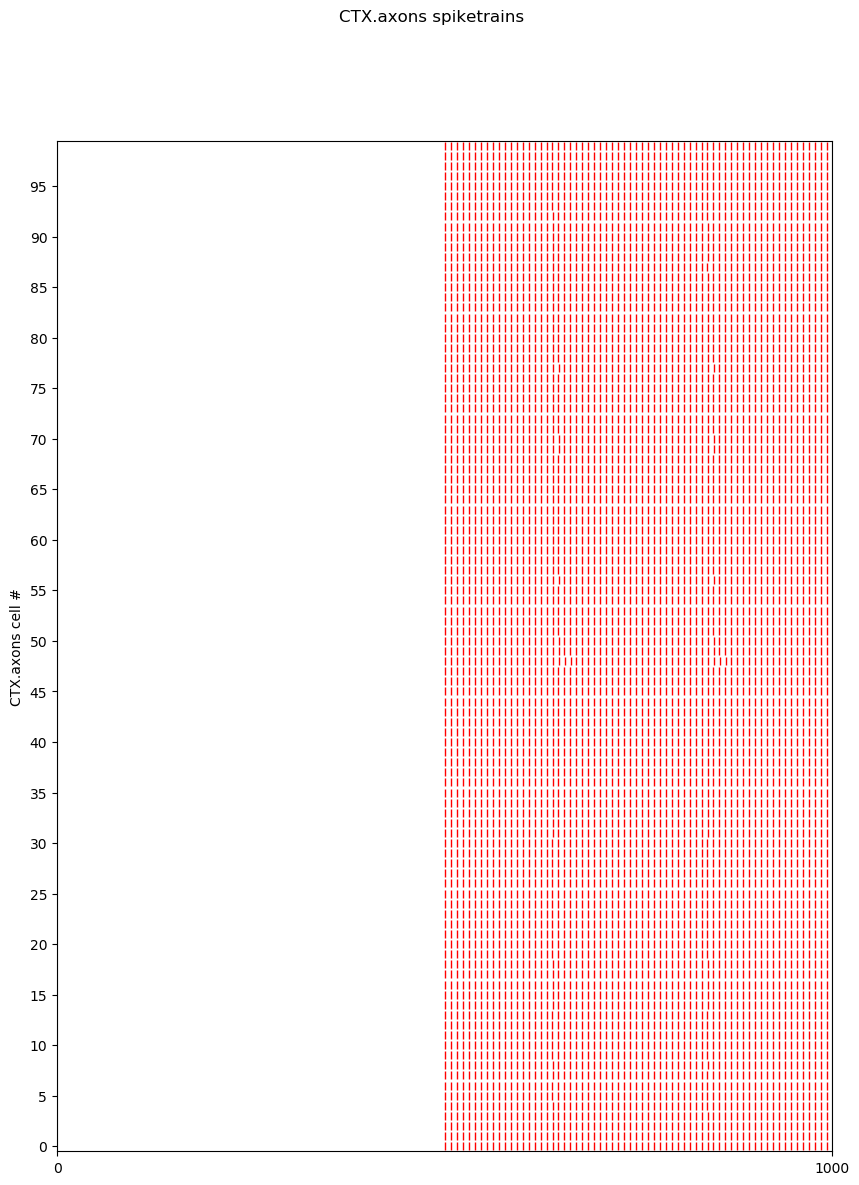

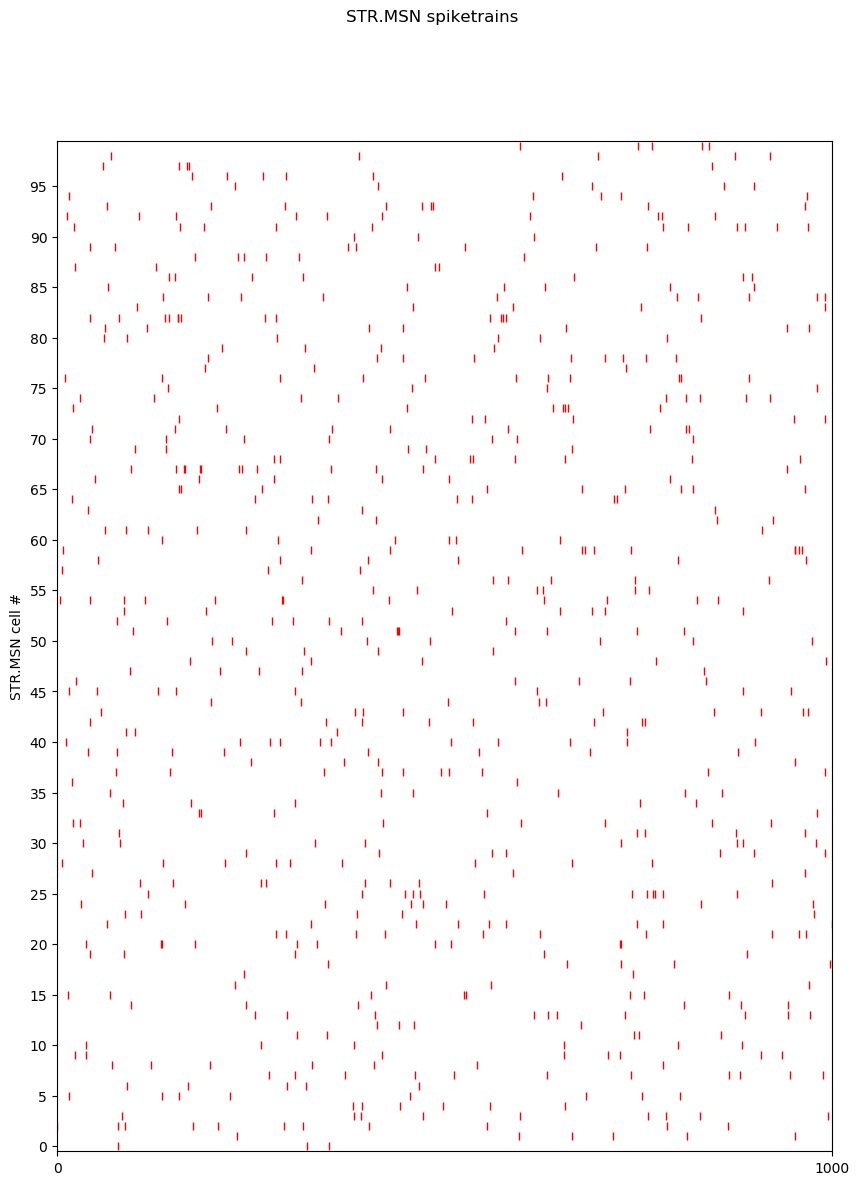

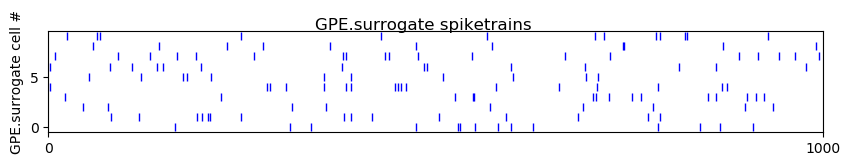

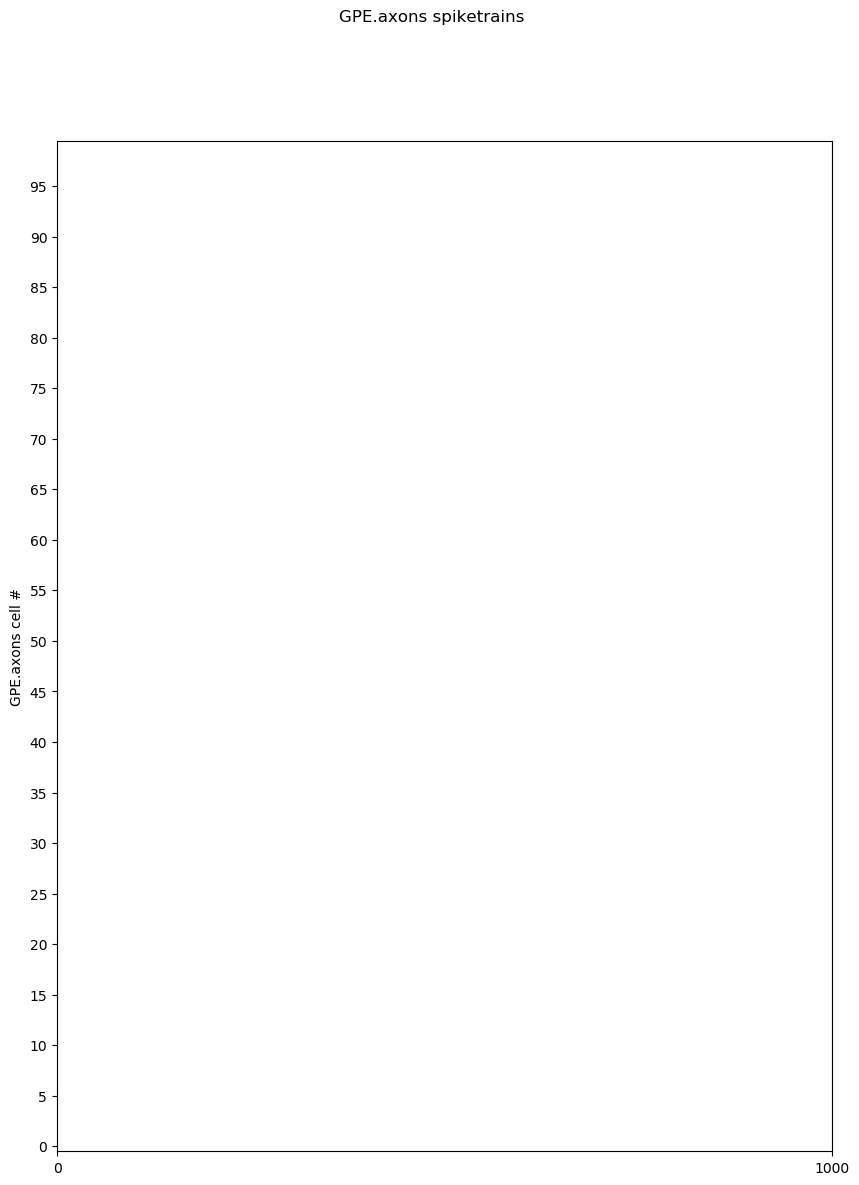

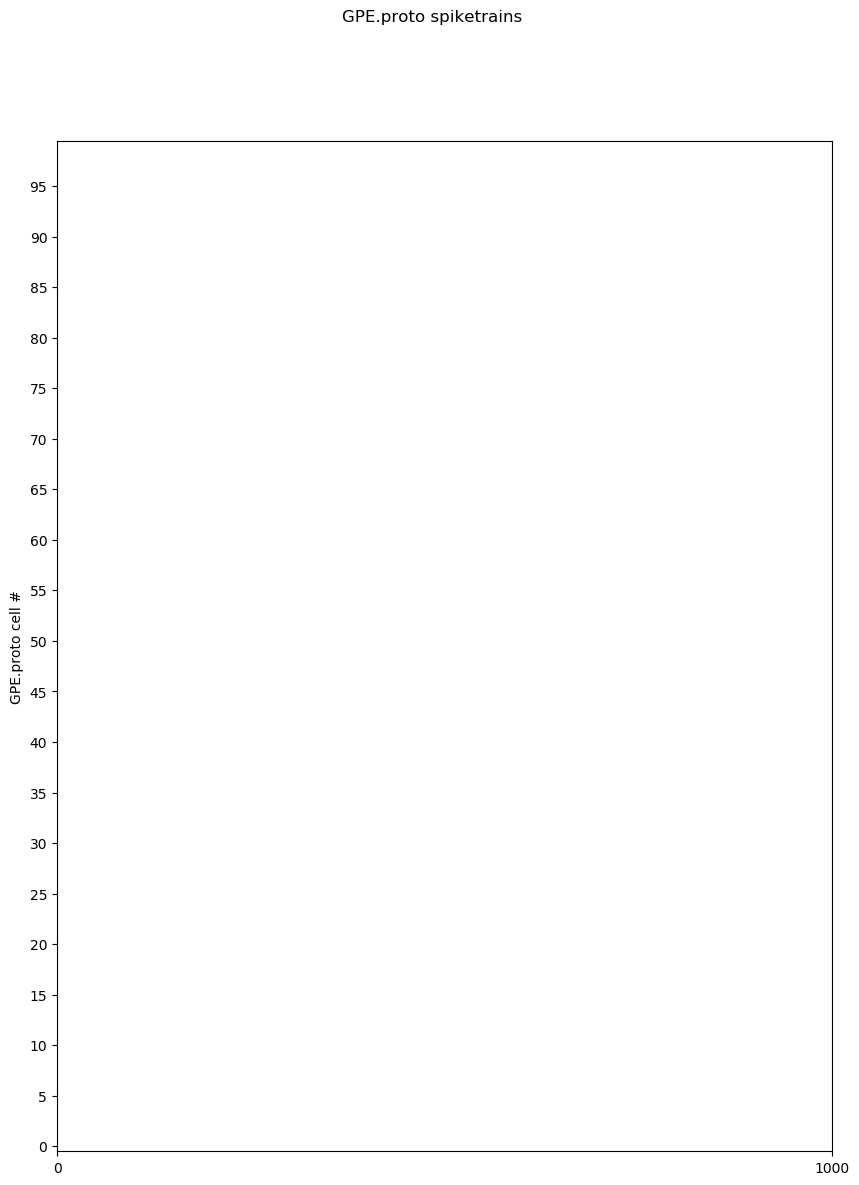

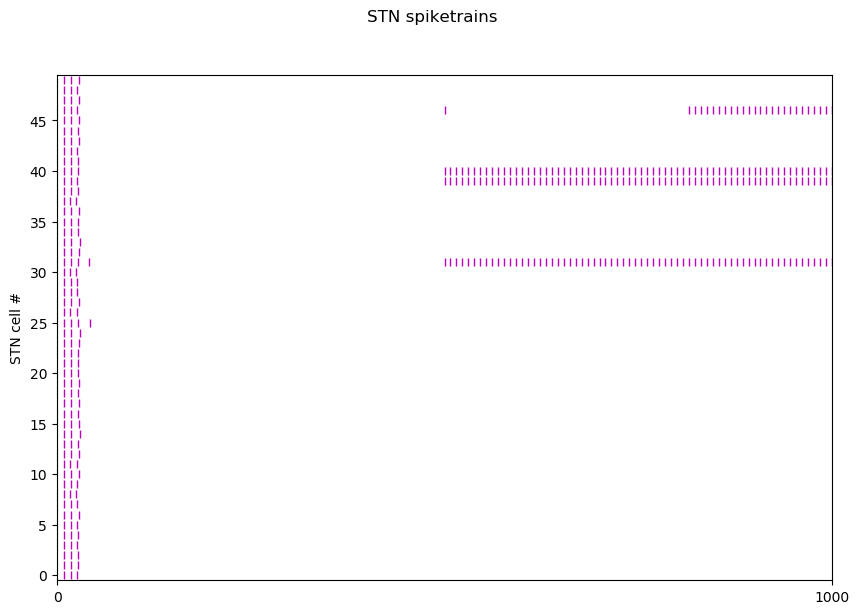

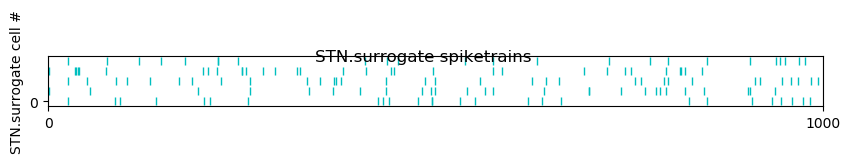

In [18]:
# Choose populations and cells indices to plot
shared_axis = None
for pop_label in sorted(pop_labels, key=get_pop_order):
    segment = pops_segments[pop_label]
    max_num_plot = 100
    num_spiketrains = min(len(segment.spiketrains), max_num_plot)
    # SETPARAM: choose cells to plot
    cell_indices = (0 + np.arange(num_spiketrains, dtype=int)) % len(segment.spiketrains)
    t_interval = ROI_INTERVAL # SETPARAM: time interval
    fig_height = ax_height*num_spiketrains/20.0
    # NOTE: don't use sharey when different population sizes
    fig, shared_axis = plot_spiketrain(pop_label, cell_indices, t_interval,
                                       sharex=shared_axis, sharey=None,
                                       figsize=(page_width, fig_height), plot_compact=False)

# plot_spiketrain('STN', range(20), (0.0, 5e3))

### ARTICLE

In [ ]:
# TODO: generate figure for article, save as eps/pgf/pdf
for pop_label in 'STN', 'GPE.proto':
    segment = pops_segments[pop_label]
    max_num_plot = 20
    num_spiketrains = min(len(segment.spiketrains), max_num_plot)
    # SETPARAM: choose cells to plot
    cell_offset = 0
    cell_indices = (cell_offset + np.arange(num_spiketrains, dtype=int)) % len(segment.spiketrains)
    t_width = 1000
    t_offset = 0
    t_interval = ROI_INTERVAL[0]+t_offset, ROI_INTERVAL[0]+t_offset+t_width # SETPARAM: time interval
    fig_size = (0.9*fig_width, ax_height*num_spiketrains/20.0)
    # NOTE: don't use sharey when different population sizes
    fig, shared_axis = plot_spiketrain(pop_label, cell_indices, t_interval,
                                       sharex=None, sharey=None,
                                       figsize=fig_size, ticks_dx=.5e3,
                                       export=True, plot_compact=False, grid=False)

# Raw Signals

In [ ]:
def plot_vm_signals(signal, cell_indices, interval, interval_only=True):
    
    rec_dt = signal.sampling_period.magnitude
    tstart = signal.t_start.magnitude
    irange = [0, signal.shape[0]-1] if interval is None else [int((t-tstart)/rec_dt) for t in interval]
    times = signal.times[irange[0]:irange[1]]
    
    fig, axes = plt.subplots(len(cell_indices), 1, 
                             figsize=(0.75*page_width,2*ax_height),
                             sharex=True, sharey=True)
    fig.suptitle("{} membrane voltage".format(pop_label))

    # Plot each Vm on separate axis
    for i_ax, i_cell in enumerate(cell_indices):
        try:
            ax = axes[i_ax]
        except TypeError:
            ax = axes
        if 'source_ids' in signal.annotations:
            label = "id {}".format(signal.annotations['source_ids'][i_cell])
        else:
            label = "cell {}".format(i_cell)
        
        if interval_only:
            ax.plot(times, signal[irange[0]:irange[1], i_cell], label=label)
        else:
            ax.plot(signal.times, signal[:, i_cell])
        
        ax.grid(True)
        ax.set_ylim((-90, 25))
        ax.set_xlim((times[0].magnitude, times[-1].magnitude))
        # ax.legend()

        if i_ax == len(cell_indices)-1:
            #ax.set_ylabel("voltage ({})".format(signal.units))
            ax.set_xlabel('time ({})'.format(times.units))

    fig.text(0.06, 0.5, "voltage ({})".format(signal.units), va='center', rotation='vertical')
    fig.subplots_adjust(bottom=0.15) # prevent clipping of xlabel

## STN Vm

In [ ]:
pop_label = 'STN'
segment = pops_segments[pop_label]
signal = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))
all_vm_signals[pop_label] = stn_vm_signal = signal
all_sigmean[pop_label + '_Vm'] = signal.duplicate_with_new_array(signal.mean(axis=1).reshape((-1,1)))

In [ ]:
# Choose plot interval and cell indices
max_num_plot = 10
num_signals = min(signal.shape[1], max_num_plot)
interval = ROI_INTERVAL # SETPARAM: plot interval
cell_indices = [i+10 for i in range(num_signals)]
plot_vm_signals(stn_vm_signal, cell_indices, interval, interval_only=False)

## GPe Vm

In [ ]:
pop_label = 'GPE.proto'
segment = pops_segments[pop_label]
all_vm_signals[pop_label] = gpe_vm_signal = signal = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))
all_sigmean[pop_label + '_Vm'] = signal.duplicate_with_new_array(signal.mean(axis=1).reshape((-1,1)))

In [ ]:
# Choose plot interval and cell indices
max_num_plot = 10
num_signals = min(signal.shape[1], max_num_plot)
interval = ROI_INTERVAL # [2000.0, 6000.0]
cell_indices = range(5) # range(num_signals)
plot_vm_signals(gpe_vm_signal, cell_indices, interval)

## CTX Artificial

Convolve spike times with stereotypical AP to obtain artificial voltage signal.

In [ ]:
pop_label = 'CTX'
segment = pops_segments['CTX']
spiketrains = segment.spiketrains[0:100] # select subset of spiketrains

In [ ]:
# Load Pyramidal cell action potential from saved recording
pyramidal_trace = np.loadtxt('../../KlmnNetMorpho/analysis/pyramidal.dat')
vm = pyramidal_trace[:,1]
tvec = pyramidal_trace[:,0]
dt = np.round(tvec[1] - tvec[0], 4)
ap_t_interval = [4.9, 20.0]
ap_i_interval = [int(t/dt) for t in ap_t_interval]
subsample = 2
ap_range = range(ap_i_interval[0], ap_i_interval[1]+1, subsample)
ap_kernel = vm[ap_range]
ap_baseline = -65.0
ap_kernel -= ap_baseline # center on 0 for convolution

plt.figure(figsize=(6,2))
plt.plot(tvec[ap_range], ap_kernel)
plt.suptitle('AP kernel for cortical neurons')
plt.grid(True)

In [ ]:
# Construct AnalogSignal of N channels from N spiketrains
dur = np.round(spiketrains[0].duration.magnitude, 4)
tstart = np.round(spiketrains[0].t_start.magnitude, 4)
tstop = np.round(spiketrains[0].t_stop.magnitude, 4)
dt = stn_vm_signal.sampling_period.magnitude
signal_matrix = np.empty((int(dur/dt)+1, len(spiketrains)))

# Convolution operation for each spiketrain
for i, st in enumerate(spiketrains):
    
    time = np.arange(tstart, tstop + dt, dt)
    spiketimes = st.times.magnitude
    spike_pulses = np.zeros_like(time)
    spike_pulses[[int((t-tstart)/dt) for t in spiketimes]] = 1.0
    
    # Convole pulses at spike times with AP kernel
    spike_signal = np.convolve(spike_pulses, ap_kernel, mode='same') + ap_baseline
    signal_matrix[:, i] = spike_signal[:signal_matrix.shape[0]]
    assert (abs(signal_matrix.shape[0] - spike_signal.size) <= 2)

# Resulting Neo signals
ctx_vm_signal = neo.AnalogSignal(signal_matrix, units='mV', sampling_period=dt*pq.ms,
                                t_start=spiketrains[0].t_start, t_stop=spiketrains[0].t_stop)
all_vm_signals[pop_label] = ctx_vm_signal

# ctx_vm_mean = ctx_vm_signal.sum(axis=1) / ctx_vm_signal.shape[1]
ctx_vm_mean = signal.duplicate_with_new_array(ctx_vm_signal.mean(axis=1).reshape((-1,1)))
all_sigmean[pop_label + '_Vm'] = ctx_vm_mean

In [ ]:
# Plot artificial signal to verify
max_num_plot = 10
num_signals = min(ctx_vm_signal.shape[1], max_num_plot)
interval = ROI_INTERVAL # [12.75e3, 14e3]
cell_indices = range(num_signals)
plot_vm_signals(ctx_vm_signal, cell_indices, interval, interval_only=False)

# Phase Analysis

Phase locking to reference signal. Should only be executed if there are Beta inputs to lock onto.

**TODO**: check in config whether the ROI_INTERVAL overlaps with a Beta inputs period.

## Reference Phase

In [ ]:
# Take 10 cells within shorter time interval
PHASE_INTERVAL = ROI_INTERVAL # SETPARAM: time interval for phase analysis
islice = neoutil.make_slice(signal, PHASE_INTERVAL)

# Choose reference signal for phase extraction
# Choose intervals to analyze spike-phase locking
phase_extraction_method = reference_phase['method']
if phase_extraction_method == 'from_ctx':
    ref_pop = 'CTX'
    locking_intervals = sim_config['CTX']['spiking_pattern']['intervals'] # for calculation of vector length
elif phase_extraction_method == 'from_stn':
    ref_pop = 'STN'
    locking_intervals = [PHASE_INTERVAL]
elif phase_extraction_method == 'from_gpe':
    ref_pop = 'GPE.proto'
    locking_intervals = [PHASE_INTERVAL]
else:
    raise ValueError("Unknown method for reference phase extraction: " + phase_extraction_method)

# We hilbert transform individual traces and mean signal
signal = all_vm_signals[ref_pop]
sigmean = all_sigmean[ref_pop + '_Vm']

num_traces = min(100, signal.shape[1])
pslice = np.s_[0:num_traces]
traces_raw = signal[islice, pslice]
times = signal.times[islice]

In [ ]:
# Plot signal for reference phase extraction
fig, ax = plt.subplots(figsize=(0.75*page_width, ax_height))
ax.set_title("Reference signal for phase extraction")

plot_ival = (PHASE_INTERVAL[1]-1000, PHASE_INTERVAL[1]) # SETPARAM: plot interval
plot_slice = neoutil.make_slice(sigmean, plot_ival)

ax.plot(sigmean.times[plot_slice], sigmean[plot_slice], color='b', label='Vref = ' + sigmean.name)
# ax.plot(ctx_vm_mean.times[plot_slice], ctx_vm_mean[plot_slice], color='b', label='Vref_phi')
ax.set_ylabel('Vm (mV)')
ax.grid(True)
ax.legend()

### Filtering

Band-pass filter in frequency band where we want to measure phase differences.

In [ ]:
# Band-pass filter in frequency band where we want to measure phase differences
Fs = signal.sampling_rate.rescale('Hz').magnitude
Fn = Fs / 2. # Nyquist frequency

def get_hilbert_passband(phase_spec):
    """
    Get passband for Hilbert transform from configuration.
    """
    band_spec = phase_spec['passband']
    if isinstance(band_spec, (tuple, list)):
        hpfreq, lpfreq = band_spec
    if isinstance(band_spec, dict):
        if isinstance(band_spec['center'], (tuple, list)):
            f_band_mid = band_spec['center'][sweep_index]
        else:
            f_band_mid = band_spec['center']
        if isinstance(band_spec['width'], (tuple, list)):
            f_band_width = band_spec['width'][sweep_index]
        else:
            f_band_width = band_spec['width']
        hpfreq = f_band_mid - f_band_width / 2.0
        lpfreq = f_band_mid + f_band_width / 2.0
    return hpfreq, lpfreq

hpfreq, lpfreq = get_hilbert_passband(reference_phase)
order = 4

# NOTE: using filtfilt/sosfiltfilt, the phase shift is corrected
assert hpfreq < lpfreq
low, high = hpfreq / Fn, lpfreq / Fn
sos = scipy.signal.butter(order, [low, high], btype='bandpass', analog=False, output='sos')

# Plot filter response
w, h = scipy.signal.sosfreqz(sos, np.linspace(0, np.pi, 2**np.ceil(np.log2(Fn))))
angles = np.unwrap(np.angle(h))
fax = w * Fn / (np.pi)

fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Filter response (2*pi = {})".format(Fs))
ax = axes[0]
ax.plot(fax, abs(h), 'b') # 20 * np.log10(abs(h))
ax.set_ylabel('Amplitude [dB]', color='b')
ax.grid(True)

ax = axes[1] # ax2 = ax.twinx()
ax.plot(fax, angles, 'g')
ax.set_ylabel('Angle (radians)', color='g')

ax.set_xlim((0, 50))
ax.set_xlabel('Frequency [Hz]')
ax.grid(True)

In [ ]:
# Filter signal
data = np.asarray(signal)
signal_bp = signal.duplicate_with_new_array(scipy.signal.sosfiltfilt(sos, data, axis=0))
sigmean_bp = signal.duplicate_with_new_array(scipy.signal.sosfiltfilt(sos, np.asarray(sigmean), axis=0))

In [ ]:
# Subsample signals for efficiency

# Traces: subsample to preserve up to 2 x highest frequency
fmax = 1000.0 # resolution of 1 ms for phase # 2 * lpfreq
fs_old = signal.sampling_rate.rescale('Hz').magnitude 
subsample_factor = int(fs_old / (2 * fmax))
subsample_factor = min(20, subsample_factor) # don't subsample more than 20x (20.000 -> 1.000 Hz)
signal_bpss = signal_bp[::subsample_factor, :] # adjusts 'sampling period' attribute

# Adjust indices of intervals
Ts_bpss = signal_bpss.sampling_period.magnitude
islice_ss = neoutil.make_slice(signal_bpss, PHASE_INTERVAL)
times_ss = signal_bpss.times[islice_ss]

# Reference signal: subsample but with small enough time resolution to look up spike phases
ss_factor_ref = int(0.25 / signal.sampling_period.magnitude) # 0.25 ms resolution: 1/200 of 20 Hz beta
sigmean_bpss = sigmean_bp[::ss_factor_ref, :]
Ts_ref = sigmean_bpss.sampling_period.magnitude

### Hilbert Transform

In [ ]:
# Compute analytic signal - magnitude and phase
from scipy.signal import hilbert

traces_bp = signal_bpss[islice_ss, 0:num_traces]
traces_raw = signal[islice, 0:num_traces]

# Hilbert transform individual reference signals
analytic_signal = hilbert(traces_bp, axis=0)
analytic_mag = np.abs(analytic_signal)
analytic_phase = np.angle(analytic_signal)

# Hilbert transform mean reference signal
analsig_sigmean = hilbert(sigmean_bpss, axis=0)
analmag_sigmean = np.abs(analsig_sigmean)
analphase_sigmean = np.angle(analsig_sigmean)

# NOTE: phases are already wrapped
# analytic_phase = np.unwrap(np.angle(analytic_signal), axis=0) # transform angle in interval (0, 2*pi)

In [ ]:
# Check result : plot filtered signals
def plot_analytic_signal(signal, bandpass, magnitude, phase, interval):
    fig, axes = plt.subplots(3, 1, figsize=(0.75*page_width,2*ax_height), sharex=True, sharey=False)
    fig.suptitle("Vmean: Filtered & Analytic Signal")

    iplot_orig = neoutil.make_slice(signal, interval)
    iplot_phas = neoutil.make_slice(bandpass, interval)

    # Band-pass filtered trace
    ax = axes[0]
    ax.plot(signal.times[iplot_orig], signal[iplot_orig], color='b', label='Vref')
    ax.plot(bandpass.times[iplot_phas], bandpass[iplot_phas] + signal.max(), color='g', label='Vref_BP')
    ax.set_ylabel('Vm (filtered)')
    ax.grid(True)
    ax.legend()
    # ax.set_ylim((-80, 25))

    # Magnitude of analytic signal = amplitude envelope
    ax = axes[1]
    ax.plot(bandpass.times[iplot_phas], magnitude[iplot_phas], label='magnitude')
    ax.set_ylabel('|analytic| [mV]')
    ax.grid(True)

    # Phase of analytic signal
    ax = axes[2]
    ax.plot(bandpass.times[iplot_phas], phase[iplot_phas], label='phase')
    ax.grid(True)
    ax.set_ylabel('angle(analytic) [rad]')
    ax.set_xlabel('time ({})'.format(times.units))

In [ ]:
# Analytic signal of the mean reference signal
plot_ival = (PHASE_INTERVAL[1]-1000, PHASE_INTERVAL[1]) # SETPARAM: plot interval
plot_analytic_signal(sigmean, sigmean_bpss, analmag_sigmean, analphase_sigmean, plot_ival)

In [ ]:
# Analytic signal for one representative trace
tid = 1
plot_analytic_signal(traces_raw[:,tid], traces_bp[:,tid], 
                     analytic_mag[:,tid], analytic_phase[:,tid],
                     plot_ival)

## Mean Phase Vector

To test the degree of phase locking to the reference signal (mean CTX Vm), we compare the STN spike times to the analytic signal of the reference.

See method description Sharott et al. (2016) and (2018)

- Hilbert transform on reference signal
- for each spike of each neuron: save the phase vector at spike time (angle + magnitude of Hilbert transform)
- for mean vector length: 
    + it does not make sense to use the magnitude of the Hilbert transform since this is for the reference signal. 
    + It makes more sense to normalize each vector to length one (scale each component by vectorn norm). 
    + As described in [this nature article](https://www.nature.com/articles/srep35135#methods-and-materials): *"The circular mean of the spike phases was calculated by taking the weighted sum of the cosine and sine of the angles, finally resulting in, the mean angle and mean vector length (R) over the number of spikes"*

In [ ]:
# Normalize and sample the complex analytic signal
analsig_norm = analsig_sigmean / np.abs(analsig_sigmean)
# analsig_norm = analsig_sigmean / np.sqrt(analsig_sigmean.real**2 + analsig_sigmean.imag**2)
# analsig_norm = analsig_sigmean / np.sqrt(analsig_sigmean * analsig_sigmean.conjugate())
spike_phase_vectors = {}

# Phase vectors are calculated using the mean reference signal
def calc_mean_phase_vectors(spiketrains, pop_label):
    """
    Calculate mean phase vector of spikes with reference to given analytic signal
    (e.g. BP filtered + Hilbert transformed).
    
    The mean phase vector for a cell (spike train) is obtained by looking up the 
    complex value of the normalized analytic signal at each spike time, 
    and averaging over all spikes in the spike train.
    
    The population phase vector is obtained by taking the mean complex value
    of all cell phase vectors in the population.
    
    Returns
    -------
    
    @return    mean_phase_vec : numpy.array(dtype=complex)
               Array containing mean phase vector of each spike train as rows.
    
    @return    pop_phase_vec : complex
               Mean phase vector over all cells in population.
    """
    # Gather spiketimes that fall within intervals of cortical beta bursts
    spikes_during = [] # list of numpy array
    for i, st in enumerate(spiketrains):
        spiketimes = st.magnitude
        mask = np.zeros_like(spiketimes, dtype=bool)
        for ival in locking_intervals:
            mask = mask | ((spiketimes > ival[0]) & (spiketimes <= ival[1]))
        spikes_during.append(spiketimes[mask])


    Ts = sigmean_bpss.sampling_period.magnitude
    t_start = sigmean_bpss.t_start.magnitude
    mean_phase_vecs = []
    spike_phase_vecs = []
    for i, spiketimes in enumerate(spikes_during):
        analsig_indices = np.round((spiketimes-t_start)/ Ts).astype(int) # indices into analytic signal
        analsig_indices = analsig_indices[analsig_indices < analsig_norm.size]
        if analsig_indices.size > 0:
            cell_spike_phase_vecs = analsig_norm[analsig_indices]
            mean_phase_vecs.append(np.mean(cell_spike_phase_vecs)) # mean of normalized phase vectors
            spike_phase_vecs.append(cell_spike_phase_vecs)
        else:
            mean_phase_vecs.append(np.array([0 + 0j]))
    
    # Save phase vectors for export
    exported_data['cell_phase_vecs'][pop_label] = mean_phase_vecs = np.array(mean_phase_vecs)
    exported_data['pop_phase_vecs'][pop_label] = pop_phase_vec = np.mean(mean_phase_vecs)
    spike_phase_vectors[pop_label] = spike_phase_vecs
    
    return mean_phase_vecs, pop_phase_vec

def subtract_phase(vecs, ref_vec):
    """
    Subtract angle of reference vector from all given vectors.
    Vectors are given as complex numbers.
    """
    adj_ang = np.angle(vecs) - np.angle(ref_vec)
    pop_mag = np.abs(vecs)
    pop_vec = pop_mag * np.cos(adj_ang) + 1j * pop_mag * np.sin(adj_ang)

In [ ]:
def plot_phase_vectors(mean_phase_vecs, pop_phase_vec, pop_label, export=False,
                       rmax=None, rticks=None, rticks_pos=None,
                       cell_color='green', pop_color='red', cell_opacity=0.5, 
                       mark_cells_rim=False, ref_vec=None, extra_pop_vecs=None,
                       extra_cell_vecs=None, extra_labels=None, extra_colors=None,
                       extra_cell_colors=None, pop_line_width=3, show_legend=True):
    """
    Plot mean phase vectors for individual neurons and whole population
    in Polar coordinates.
    """
    if extra_pop_vecs is None:
        extra_pop_vecs = []
    
    # Reference angle for all plotted vectors
    if ref_vec is None:
        ref_ang = 0.0
    else:
        ref_ang = np.angle(ref_vec)
    
    # Complex vectors to polar coordinates
    vec_angs = np.angle(mean_phase_vecs) - ref_ang
    vec_lens = np.abs(mean_phase_vecs)
    pop_ang = np.angle(pop_phase_vec) - ref_ang
    pop_mag = np.abs(pop_phase_vec)
    if rmax is None:
        rmax = (vec_lens.max() // 0.1 + 1) * 0.1
    if rticks is None:
        rticks = np.arange(0.1, 1.1, 0.1)
    
    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')
    
    # Plot additional vectors if given
    for i, vec in enumerate(extra_pop_vecs):
        if extra_cell_vecs is not None:
            extra_angs = np.angle(extra_cell_vecs[i]) - ref_ang
            extra_lens = np.abs(extra_cell_vecs[i])
            ax.vlines(extra_angs, 0, extra_lens, color=extra_cell_colors[i],
                      alpha=cell_opacity, linewidth=1, snap=True)
        # Population vector after/over cell vectors
        ax.vlines(np.angle(vec) - ref_ang, 0, np.abs(vec), color=extra_colors[i],
                  linewidth=pop_line_width, label=extra_labels[i])
    
    # Plot cell vectors as points on outer circle
    ax.vlines(vec_angs, 0, vec_lens, 
              color=cell_color, alpha=cell_opacity, linewidth=1, snap=True)
    if mark_cells_rim:
        ax.plot(vec_angs, np.zeros_like(vec_angs)+rmax, 'o', 
                color=cell_color, markersize=5)
    
    # Plot population vector as thick line
    # ax.plot(vec_angs, vec_lens, 'ro')
    ax.vlines(pop_ang, 0, pop_mag, label=pop_label,
              color=pop_color, linewidth=pop_line_width)
    
    # Format axes
    ax.grid(True)
    ax.set_rticks(rticks) # less radial ticks
    ax.set_rmax(rmax)
    if rticks_pos is not None:
        ax.set_rlabel_position(rticks_pos)  # Move radial labels away from plotted line
    ax.tick_params(axis='y', labelsize=14)  # labelcolor='blue'
    ax.tick_params(axis='x', labelsize=14)
    if show_legend:
        ax.legend(loc=(1, .8))
    # ax.set_title('Mean angle and vector length of {} neurons'.format(pop_label), va='bottom')
    

    # kw = dict(arrowstyle="->", color='g')
    # for angle, radius in zip(phases, magnitudes):
    #     ax.annotate("", xy=(angle, radius), xytext=(0, 0), arrowprops=kw)
    
    if export_figs and export:
        fname = 'phase-vectors_{}'.format(pop_label)
        save_figure(fname, fig=fig)

In [ ]:
def plot_phase_histogram(pop_label, ref_vec=None, num_bins=20,
                         face_alpha=0.1, bar_color='blue', export=False,
                         rlabel_angle='default', rmax=None, rticks=None,
                         rlabel_start=0.0):
    """
    Plot mean phase vectors for individual neurons and whole population
    in Polar coordinates.
    """
    # Reference angle for all plotted vectors
    if ref_vec is None:
        ref_ang = 0.0
    else:
        ref_ang = np.angle(ref_vec)
    
    # Complex vectors to polar coordinates
    all_spike_vecs = np.concatenate(spike_phase_vectors[pop_label], axis=0)
    assert (all_spike_vecs.ndim == 1) or (min(all_spike_vecs.shape) == 1)
    vec_angs = np.angle(all_spike_vecs) - ref_ang
    
    # Histogram of phase angles
    bin_counts, bin_edges = np.histogram(vec_angs, bins=num_bins, range=(-np.pi, np.pi))
    bin_fractions = bin_counts.astype(float) / np.sum(bin_counts)
    bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(num_bins)]

    fig = plt.figure()
    ax = plt.subplot(111, projection='polar')

    # Use custom colors and opacity
    bar_width = 2*np.pi / len(bin_counts)
    bars = ax.bar(bin_centers, bin_fractions, width=bar_width, bottom=0.0)
    r, g, b = matplotlib.colors.to_rgb(bar_color)
    for bar in bars:
        bar.set_facecolor((r, g, b, face_alpha))
        bar.set_edgecolor(bar_color)
        # bar.set_alpha(0.1)
    
    # Format axes
    if rticks is not None:
        ax.set_rticks(rticks)
    if rmax is not None:
        ax.set_rmax(rmax)
    grid_color = 'gray'
    ax.grid(True, color=grid_color)
    # Appearance of radial tick labels
    if rlabel_start:
        ax.set_yticklabels([str(r) if r >= rlabel_start else '' for r in ax.get_yticks()])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)  # labelcolor=grid_color
    if rlabel_angle == 'minimum':
        label_pos = np.degrees(bin_centers[bin_counts.argmin()]) + 9
        ax.set_rlabel_position(label_pos)
    elif isinstance(rlabel_angle, (float, int)):
        ax.set_rlabel_position(rlabel_angle)
    
    if export_figs and export:
        fname = 'phase-histogram_{}'.format(pop_label)
        save_figure(fname, fig=fig)

### CTX phase vectors

In [ ]:
pop_label = 'CTX'
spiketrains = pops_segments[pop_label].spiketrains[:100] # select subset of spiketrains

# Calculate neuron and population phase vectors
ctx_cell_vecs, ctx_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label)

# Show in polar plot
plot_phase_vectors(ctx_cell_vecs, ctx_pop_vec, pop_label,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False)

### MSN phase vectors

In [ ]:
pop_label = 'STR.MSN'
spiketrains = pops_segments[pop_label].spiketrains[:100] # select subset of spiketrains

# Calculate neuron and population phase vectors
msn_cell_vecs, msn_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label)

# Show in polar plot
plot_phase_vectors(msn_cell_vecs, msn_pop_vec, pop_label,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False)

### STN phase vectors

In [ ]:
pop_label = 'STN'
segment = pops_segments['STN']
spiketrains = segment.spiketrains[:] # select subset of spiketrains

# Calculate neuron and population phase vectors
stn_cell_vecs, stn_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label)

# Show in polar plot
extra_args = {
    'extra_pop_vecs': [ctx_pop_vec, msn_pop_vec],
    'extra_colors': ['c', 'm'],
    'extra_labels': ['CTX', 'MSN'],
}
plot_phase_vectors(stn_cell_vecs, stn_pop_vec, pop_label, ref_vec=ctx_pop_vec,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=False,
                   **extra_args)

plot_phase_histogram(pop_label, ref_vec=ctx_pop_vec, num_bins=20,
                     bar_color=get_pop_color(pop_label),
                     rticks=np.arange(0, 0.25, 0.02), rmax=0.1, 
                     rlabel_start=0.05, export=True)

### GPE phase vectors

In [ ]:
pop_label = 'GPE.proto'
spiketrains = pops_segments[pop_label].spiketrains[:] # select subset of spiketrains

# Calculate neuron and population phase vectors
gpe_cell_vecs, gpe_pop_vec = calc_mean_phase_vectors(spiketrains, pop_label)

# Show in polar plot
extra_args = {
    'extra_pop_vecs': [ctx_pop_vec, msn_pop_vec, stn_pop_vec],
    'extra_colors': ['c', 'm', 'g'],
    'extra_labels': ['CTX', 'MSN', 'STN'],
}
plot_phase_vectors(gpe_cell_vecs, gpe_pop_vec, 'GPE', ref_vec=ctx_pop_vec,
                   cell_color='grey', pop_color=get_pop_color(pop_label),
                   rmax=0.8, rticks=np.arange(.2,1.2,.2), export=False,
                   **extra_args)

plot_phase_histogram(pop_label, ref_vec=ctx_pop_vec,
                     bar_color=get_pop_color(pop_label),
                     rticks=np.arange(0, 0.5, 0.1), rmax=0.4,
                     rlabel_start=0.1, rlabel_angle=115, export=True)

### ARTICLE

In [ ]:
# Combine on single ploar plot
# https://xkcd.com/color/rgb/
extra_args = {
    'extra_pop_vecs': [gpe_pop_vec],
    'extra_cell_vecs': [gpe_cell_vecs],
    'extra_colors': ['xkcd:red'],
    'extra_cell_colors': ['xkcd:pinkish'],
    'extra_labels': ['GPE'],
}
pop_label = 'STN+GPE'
plot_phase_vectors(stn_cell_vecs, stn_pop_vec, pop_label, ref_vec=gpe_pop_vec,
                   pop_color='xkcd:forrest green', show_legend=False,
                   cell_color='green', cell_opacity=0.3, pop_line_width=5,
                   rmax=1.0, rticks=np.arange(.2,1.2,.2), export=True,
                   **extra_args)

# Power Spectra

## PSD

In [ ]:
def calc_psd(pop_label, interval=None, vm_sig=None):
    """
    Calculate PSD from membrane voltages of population.
    
    It computes the PSD for the individual Vm traces and then
    averages the resulting PSDs.
    """
    if vm_sig is None:
        segment = pops_segments[pop_label]
        vm_sig = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))

    Ts = vm_sig.sampling_period.magnitude # ms
    fs = vm_sig.sampling_rate.rescale('Hz').magnitude
    
    islice = neoutil.make_slice(vm_sig, interval)
    vm_segment = vm_sig[islice, :]
    
    dF = max(0.5, fs / vm_segment.shape[0]) # dF for max window size is finest possible
    if dF != 0.5:
        print("Adjusted frequency resolution to data size: dF = {}".format(dF))
    
    # Compute PSD of all 100 Vm signals at the same time
    freqs, psd = elephant.spectral.welch_psd(vm_segment, freq_res=dF)
    
    # Average individual trace PSDs
    psd_avg = psd.sum(axis=0) / psd.shape[0]
    psd_rel = psd_avg[0:int(250/dF)] # relevant region of psd

    # Save PSD
    all_psd[pop_label+'_Vm'] = (freqs, psd_avg)
    
    # Save units for other plotting functions
    global psd_units
    psd_units = psd.units
    
    return freqs, psd_avg


def plot_psd(freqs, psd_avg, pop_label):
    """
    Plots PSD on relative and absolute axis for comparison with others.
    """
    fig, ax = plt.subplots(figsize=(page_width*0.5, ax_height))
    ax.plot(freqs, psd_avg, label='{} Vm'.format(pop_label))

    ax.set_ylabel('Power ({})'.format(psd_avg.units.dimensionality))
    ax.set_xlabel('frequency ({})'.format(freqs.units.dimensionality))
    ax.set_xlim((0, 50))
    ax.grid(True)
    ax.set_title('Welch PSD for mean {} Vm'.format(pop_label))
    # ax.set_yscale('log')
    # ax.legend(loc='best')

    # PSD on shared scale for comparison with other simulations
    fig, ax = plt.subplots(figsize=(page_width*0.5, ax_height))
    ax.plot(freqs, psd_avg, label='{} Vm'.format(pop_label))
    ax.set_ylabel('Power ({})'.format(psd_avg.units.dimensionality))
    ax.set_xlabel('frequency ({})'.format(freqs.units.dimensionality))
    ax.set_xlim((0, 50))
    ax.set_ylim((0, 10))
    ax.grid(True)
    ax.set_title('Welch PSD for mean {} Vm (absolute y-axis)'.format(pop_label))

### STN Vm

In [ ]:
pop_label = 'STN'

# Mean of Vm PSDs
freqs, psd_avg = calc_psd(pop_label, interval=ROI_INTERVAL)
plot_psd(freqs, psd_avg, pop_label)

# Compare to PSD of mean Vm
# !!! Here phases cancels
# segment = pops_segments[pop_label]
# signal = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))
# sigmean = signal.duplicate_with_new_array(signal.mean(axis=1).reshape((-1,1)))
# freqs, psd_avg = calc_psd(pop_label, interval=ROI_INTERVAL, vm_sig=sigmean)
# plot_psd(freqs, psd_avg, pop_label)

### GPE.proto

In [ ]:
pop_label = 'GPE.proto'
# segment = pops_segments[pop_label]

freqs, psd_avg = calc_psd(pop_label, interval=ROI_INTERVAL)

plot_psd(freqs, psd_avg, pop_label)

### CTX spikes

In [ ]:
pop_label = 'CTX'
# segment = pops_segments[pop_label]

freqs, psd_avg = calc_psd(pop_label, vm_sig=ctx_vm_signal, interval=ROI_INTERVAL)

plot_psd(freqs, psd_avg, pop_label)

## Spectrogram (STFT)

In [ ]:
def calc_spectrogram(pop_label, signal=None, max_avg=50, interval=ROI_INTERVAL):
    """
    Calculate mean spectrogram (STFT) of membrane voltage traces.
    
    The resulting time axis is missing 'nperseg' values on each side since
    each PSD sample is calculated on the interval [-nperseg/2, +nperseg/2]
    around it.
    
    @param     max_avg : int
               Number of spectrograms to compute for averaging.
               WARNING: can lead to very high memory consumption.
    
    @return    freqs, t, Sxx
               Sxx has t-dimension along axis 0 and f-dimension along axis 1.
    """
    if signal is None:
        segment = pops_segments[pop_label]
        signal = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))

    # Plot spectrogram using STFT
    dt = signal.sampling_period.magnitude
    fs = 1/dt*1e3
    freq_res = 1.0
    nperseg = int(fs/freq_res) # determines frequency resolution
    t_res = 20.0 # ms
    noverlap = nperseg - int(t_res/dt)
    islice = neoutil.make_slice(signal, interval)
    
    if signal.ndim == 2:
        # Spectrogram of all signals along axis 0
        vm_sig = signal[islice, :]
        if vm_sig.shape[1] > max_avg:
            sig_data = vm_sig.as_array()[:, 0:max_avg]
        else:
            sig_data = vm_sig.as_array()
        freqs, t, Sxx = scipy.signal.spectrogram(sig_data, 1/dt, axis=0, window='hanning',
                                                 nperseg=nperseg, noverlap=noverlap, scaling='density')

        # Average over cell dimension -> Sxx dims are now (freqs, t)
        assert sig_data.shape[1] == Sxx.shape[1]
        Sxx = Sxx.mean(axis=1)
    else:
        assert signal.ndim == 1
        sig_data = signal.ravel()[islice]
        freqs, t, Sxx = scipy.signal.spectrogram(sig_data, 1/dt, window='hanning',
                                                 nperseg=nperseg, noverlap=noverlap, scaling='density')
    
    freqs = freqs * 1000
    t = t + signal.t_start.rescale('ms').magnitude

    # Save spectrogram
    df = freqs[1]-freqs[0]
    all_spectrogram[pop_label + '_Vm'] = (freqs[0:int(50/df)], t, Sxx[:,0:int(50/df)])
    
    return freqs, t, Sxx

def plot_spectrogram(freqs, t, Sxx, pop_label, f_max=100.0, P_max=None):
    # Spectrogram 1
    fig, ax = plt.subplots(figsize=(0.75*page_width, ax_height))
    # cmap = 'viridis' / 'plasma' / 'jet'
    plt.pcolormesh(t, freqs, Sxx, cmap='viridis')
    # plt.imshow(Sxx, cmap='jet', aspect='auto', vmax=abs(Sxx).max(), vmin=Sxx.min())
    plt.ylim((0, f_max))
    plt.colorbar()
    # plt.clim(0, 20)
    if P_max is None:
        P_max = abs(Sxx[:, int(1000.0/(t[1]-t[0])):]).max() # discard first second
    plt.clim(0, P_max)
    plt.ylabel('frequency (Hz)')
    plt.xlabel('time (ms)')
    ax.set_title('Spectrogram of mean {} Vm ({})'.format(pop_label, psd_units.dimensionality))

### STN

In [ ]:
freqs, t, Sxx = calc_spectrogram('STN', max_avg=25)
plot_spectrogram(freqs, t, Sxx, 'STN', f_max=50.0)
plot_spectrogram(freqs, t, Sxx, 'STN', f_max=50.0, P_max=2000)

### GPE.proto

In [ ]:
freqs, t, Sxx = calc_spectrogram('GPE.proto')
plot_spectrogram(freqs, t, Sxx, 'GPE.proto', f_max=50.0)

### CTX spikes

In [ ]:
freqs, t, Sxx = calc_spectrogram('CTX', signal=ctx_vm_signal)
plot_spectrogram(freqs, t, Sxx, 'CTX', f_max=50.0)

# Currents

In [ ]:
# Make trigger signal for Beta based on zero-crossings of Beta phase
try:
    # PHASE AVAILABLE AFTER HILBERT TRANSFORM COMPUTED
    phase_pos = np.array(analphase_sigmean.ravel() >= 0, dtype=float)
    phase_zero_idx = np.where(np.diff(phase_pos) == 1)[0] + 1 # zero crossings in UP direction
    phase_zero_times = sigmean_bpss.times.magnitude[phase_zero_idx] # use Hilbert transformed signal
except NameError:
    # empty variables if Hilbert not calculated
    phase_pos = None
    phase_zero_idx = None
    phase_zero_times = None

In [ ]:
# Find phase locked units
for pop in 'STN', 'GPE.proto':
    cell_phase_vecs = exported_data['cell_phase_vecs'][pop] # imaginary numbers
    vec_idx_sorted = np.argsort(np.abs(cell_phase_vecs))[::-1] # sorted by magnitude in reversed order
    cell_idx_sorted = [pops_segments[pop].spiketrains[i].annotations['source_index'] for i in vec_idx_sorted]
    cell_gid_sorted = [pops_segments[pop].spiketrains[i].annotations['source_id'] for i in vec_idx_sorted]
    
    # Check that spiketrains are sorted according to cell indices in population
    assert all((i==j for i,j in zip(vec_idx_sorted, cell_idx_sorted)))
    
    exported_data.setdefault('phaselock_ranking_source_indices', {})[pop] = cell_idx_sorted
    exported_data.setdefault('phaselock_ranking_source_ids', {})[pop] = cell_gid_sorted

In [ ]:
# Function definitions for plotting
import re, collections

def get_synapse_index(trace_name):
    matches = re.search(r'(?P<index>\d+)$', trace_name)
    syn_index = matches.group('index')
    assert syn_index is not None
    return int(syn_index)


def sorted_signals(segment, trace_name):
    trace_regex = trace_name + '(\d+)'
    return sorted([sig for sig in segment.analogsignals if re.search(trace_regex, sig.name)],
                  key=lambda sig: get_synapse_index(sig.name))


def plot_signal_interval(ax, signal, interval, channels, **kwargs):
    """
    Plot neo.AnalogSignal in given interval.
    """
    rec_dt = signal.sampling_period.magnitude
    tstart = signal.t_start.magnitude
    sim_dur = signal.t_stop.magnitude
    irange = [int((t-tstart)/rec_dt) for t in interval]
    times = signal.times[irange[0]:irange[1]]
    ax.plot(times, signal[irange[0]:irange[1], channels], **kwargs)

    
def plot_synapse_traces(pop_label, max_ncell, max_nsyn, interval, interval_only=True,
                       channel_gates=None, channel_currents=None, beta_phase=True,
                       trace_names=None, extra_sigs=None, extra_plot_with=None,
                       extra_max_plot=5):
    """
    Plot Synaptic dynamics for specific cells and their recorded synapses.
    
    Typically both the cells in the population and their synapses have
    been sampled.
    
    
    @pre    If arguments 'channel_gates' and 'channel_currents' are given,
            the signals they refer to are recorded from the same cells
            as the synaptic currents and conductances. I.e. the indices
            into channel-related signals are the same as those into
            the synapse-related signals.
    """
    segment = pops_segments[pop_label]
    # NOTE: signals are akwardly ordered: one signal is the i-th synapse for all recorded cells
    default_tracenames = 'gAMPA', 'gNMDA', 'iGLU', 'gGABAA', 'gGABAB', 'iGABA'
    if trace_names is None:
        trace_names = default_tracenames
    all_synaptic_sigs = {tn: sorted_signals(segment, tn) for tn in trace_names}
    trace_groups = {k:'GABA' if ('GABA' in k) else 'GLU' for k in all_synaptic_sigs}
    signal = next((sigs[0] for sigs in all_synaptic_sigs.values() if len(sigs)>0), None)
    if signal is None:
        print("No synaptic traces for population {}".format(pop_label))
        return

    # index in all_synaptic_sigs of the synaptic traces that exist (are recorded)
    # existing_traces = [i for i,sigs in enumerate(all_synaptic_sigs.values()) if len(sigs)>0]
    existing_traces = [sig_name for sig_name, sigs in all_synaptic_sigs.items() if len(sigs)>0]
    num_ax_per_cell = len(existing_traces)
    num_cell = min(signal.shape[1], max_ncell)
    
    # Select synapses to plot.
    selected_synapses = {'GLU': [], 'GABA': []} # trace suffixes of selected synapses
    for group in selected_synapses.keys():
        tname = next((n for n in existing_traces if trace_groups[n] == group), None)
        if tname is None:
            continue
        for j_sig, sig in enumerate(all_synaptic_sigs[tname]):
            if j_sig >= max_nsyn:
                break
            selected_synapses[group].append(get_synapse_index(sig.name))

    # Get signal time data
    rec_dt = signal.sampling_period.magnitude
    tstart = signal.t_start.magnitude
    tstop = signal.t_stop.magnitude
    if interval is None:
        interval = (tstart, tstop)
    irange = [int((t-tstart)/rec_dt) for t in interval]
    times = signal.times[irange[0]:irange[1]]

    # Make the figure
    num_axes = num_cell * num_ax_per_cell
    fig, axes = plt.subplots(num_axes, 1, 
                             figsize=(0.75*page_width, num_axes*ax_height),
                             sharex=True)
    # fig.suptitle("{} synapse dynamics".format(pop_label))

    # For each cell we try to plot all synapses of one type on one axis
    # TODO: for each plotted signal, check that the cell_gid is the same
    for i_cell in xrange(num_cell):
        # One axis for all iGLU, one for all iGABA, one for each conductance type.
        # This makes a maximum of 6 axes per cell
        for i_plotted, tracename in enumerate(existing_traces):
            i_ax = (i_cell * num_ax_per_cell) + i_plotted
            try:
                ax = axes[i_ax]
            except TypeError:
                ax = axes
            
            # Plot all synapses for this axis (same conductance or current)
            ax_l_sigs = [] # signals plotted on left axis
            for j_sig, sig in enumerate(all_synaptic_sigs[tracename]):
                ax_l_sigs.append(sig)
                i_syn = get_synapse_index(sig.name)
                if i_syn in selected_synapses[trace_groups[tracename]]:
                    label = None # if j_sig>0 else ax_tracename
                    if interval_only:
                        ax.plot(times, sig[irange[0]:irange[1], i_cell], label=label)
                    else:
                        ax.plot(signal.times, sig[:, i_cell], label=label)
            
            # Save axes limits for main traces
            ymin, ymax = ax.get_ylim()
            
            # Plot Beta trigger signal (zero phase)
            if beta_phase:
                ax.vlines(phase_zero_times, ymin, ymax, label='$\phi$ = 0',
                          colors='black', linestyle='dashed', linewidths=0.5)
            
            # NOTE: cell index -> see recorder._get_current_segment() -> should save source_ids/channel_ids
            # TODO: plot spike times or Vm of source_indices in same plot
            ax_r = None
            
            # Plot additional signals on the right axis
            if channel_gates and tracename.startswith('g'):
                # Plot channel gating variables if we are plotting conductance
                ax_r = ax.twinx()
                gating_sigs = [sig for sig in segment.analogsignals if sig.name in channel_gates]
                for k, csig in enumerate(gating_sigs):
                    color, style = analysis.pick_line_options('red', 'broken', k)
                    plot_signal_interval(ax_r, csig, interval, i_cell, label=csig.name,
                                         color=color, linestyle=style)
                ax_r.legend(loc='upper right')
                ax_r.set_ylabel('open')
            elif extra_sigs and extra_plot_with(tracename):
                # Plot extra variables
                ax_r = ax.twinx()
                rax_sigs = [sig for sig in segment.analogsignals if sig.name in extra_sigs]
                for k, csig in enumerate(rax_sigs):
                    if k+1 > extra_max_plot:
                        break
                    color, style = analysis.pick_line_options('red', 'broken', k)
                    plot_signal_interval(ax_r, csig, interval, i_cell, label=csig.name,
                                         color=color, linestyle=style)
                ax_r.legend(loc='upper right')
            elif channel_currents and tracename.startswith('i'):
                # Plot channel currents if we are plotting synaptic currents
                ax_r = ax.twinx()
                curr_sigs = [sig for sig in segment.analogsignals if sig.name in channel_currents]
                for k, csig in enumerate(curr_sigs):
                    color, style = analysis.pick_line_options('red', 'broken', k)
                    plot_signal_interval(ax_r, csig, interval, i_cell, label=csig.name,
                                         color=color, linestyle=style)
                ax_r.legend(loc='upper right')
                ax_r.set_ylabel('current ($mA/cm^2$)')
            elif tracename.startswith('i') and 'source_indices' in ax_l_sigs[-1].annotations:
                # Plot membrane voltages recorded from given cell
                src_idxs = ax_l_sigs[-1].annotations['source_indices']
                cell_pop_idx = src_idxs if isinstance(src_idxs, int) else src_idxs[i_cell]
                ax_r = ax.twinx()
                # Plot somatic voltage
                vsoma = next((sig for sig in segment.analogsignals if sig.name == 'Vm'))
                plot_signal_interval(ax_r, vsoma, interval, cell_pop_idx, label=vsoma.name, 
                                     color='gray', linewidth=0.2)
                # Plot dendritic voltages
                # vm_sigs = [sig for sig in segment.analogsignals if sig.name.lower().startswith('v')]
                # for k, vsig in enumerate(vm_sigs):
                #     color, style = analysis.pick_line_options('red', 'broken', k)
                #     plot_signal_interval(ax_r, vsig, interval, i_cell, label=vsig.name,
                #                          color=color, linestyle=style)
                ax_r.legend(loc='upper right')
                ax_r.set_ylabel('Vm (mV)')
            
            # Annotation and axes
            ax.grid(True, axis='y')
            if tracename.startswith('i'):
                ax.set_ylabel('current (nA)')
            else:
                ax.set_ylabel('conductance (uS)')
            if i_plotted == 0:
                ax.set_title('{} cell {}'.format(pop_label, i_cell))
            # ax.set_xlabel('time (ms)')
            ax.set_ylim((ymin, ymax))
            ax.set_xlim((times[0].magnitude, times[-1].magnitude))
            ax.legend(loc='upper left')

## STN Synapse Dynamics

In [ ]:
%%skip $automatic_execution

# Plot synaptic conductances and currents for selected populations
t_interval = ROI_INTERVAL[0], ROI_INTERVAL[0]+400 # SETPARAM: time interval
stn_segment = pops_segments['STN']

plot_synapse_traces('STN', max_ncell=1, max_nsyn=3,
                    trace_names=['i_NR2A', 'i_GLU', 'iGABA'], # add traces you want to plot
                    extra_sigs=[sig.name for sig in stn_segment.analogsignals if (
                                   sig.name.startswith('STN_CaT_inact') or
                                   sig.name.startswith('STN_CaL_inact'))],
                    extra_plot_with=lambda trace_name: trace_name.startswith('i'),
                    extra_max_plot=5,
                    interval=t_interval, interval_only=True, beta_phase=True)

## Phase Locking Mechanism

In [ ]:
def combine_current_signals(post_pop, afferents_currents, cell_gid=None, cell_pop_idx=None):
    """
    Get combined afferent current signal for a given presynaptic population
    and synaptic current types (e.g. AMPA, NMDA currents)

    @param    afferents_currents : dict[str, list(str)]
              Map of afferent population labels to recorded synaptic current names.
              e.g.: {'CTX': ('i_AMPA', 'i_NMDA')}
    
    @return   tuple(np.array, dict[str, np.array])
              Tuple containing:
              - np.array: sum total current as a function of time
              - dict[str, np.array]: sum total current per population
    """
    pops_itot = {}
    segment = pops_segments[post_pop]

    for afferent_pop in afferents_currents.keys():
        # Current signals for afferent population, by current type (e.g. GABA-A/GABA-B)
        isyn_names = afferents_currents[afferent_pop]
        currents_traces = {curr: sorted_signals(segment, curr) for curr in isyn_names}

        # Sum current signals of same type
        currents_itot = {}
        for current, traces in currents_traces.items():
            # traces is all signals (synapses) recorded from the same synapse type
            currents_itot[current] = sum_cell_signals(traces, cell_gid=cell_gid,
                                                      cell_pop_idx=cell_pop_idx)
        # Sum current signals of different types
        pops_itot[afferent_pop] = sum(currents_itot.values())
    
    # Sum total current of all afferent populations
    allpops_itot = sum(pops_itot.values())
    return allpops_itot, pops_itot


def sum_cell_signals(traces=None, segment=None, sig_name=None,
                     cell_gid=None, cell_pop_idx=None, average=False):
    """
    Sum all signals recorded from the same cell.
    
    @param    traces : list(Neo.AnalogSignal)
              Set of signals that will be searched for traces
              recorded from the given cell.
    """
    if traces is None:
        traces = sorted_signals(segment, sig_name)
    itot = None
    for sig in traces:
        if cell_gid is not None:
            trace_idx = list(sig.annotations['source_ids']).index(cell_gid)
        elif cell_pop_idx is not None:
            trace_idx = list(sig.annotations['source_indices']).index(cell_pop_idx)
        isyn = sig.magnitude[:, trace_idx]
        itot = isyn if (itot is None) else (itot + isyn)
    if average:
        itot /= len(traces)
    print("Summed {} signals for cell gid {}".format(len(traces), cell_gid))
    return itot


def plot_oscillatory_traces(pop, exc_currents, inh_currents, ranking_slice=None,
                            interval=ROI_INTERVAL, lpf_current=100, gating_signals=None,
                            trace_group_member=None, export_indices=None):
    """
    Plot factors contributing to network oscillations & synchronization.
    
    @param    trace_group_member : str
              Name of any recorded signal in the same recorded trace group as
              plotted variabed. Used for finding cell indices.
    """
    currents_by_action = {'EXC': exc_currents, 'INH': inh_currents}
    segment = pops_segments[pop]
    
    # Get cells with recorded synapses and rank by phase locking strength
    cell_pop_idx_ranked = list(exported_data['phaselock_ranking_source_indices'][pop])
    test_signal = next((sig for sig in segment.analogsignals if 
                        sig.name.startswith(trace_group_member)))
    recorded_cell_idx = list(test_signal.annotations['source_indices'])
    print("Recorded cell indices: {}".format(recorded_cell_idx))
    print("Phase-locking ranked indices: {}".format(cell_pop_idx_ranked))
    recorded_cell_idx_ranked = sorted(recorded_cell_idx, key=lambda i: cell_pop_idx_ranked.index(i))
    plotted_cell_idx = recorded_cell_idx_ranked[ranking_slice]
    print("Ranked recorded cells: {}".format(recorded_cell_idx_ranked))
    
    # Get signal time data
    rec_dt = signal.sampling_period.magnitude
    tstart = signal.t_start.magnitude
    tstop = signal.t_stop.magnitude
    t0, t1 = interval
    irange = [int((t-tstart)/rec_dt) for t in interval]
    times = signal.times[irange[0]:irange[1]]
    
    # Phase signal
    phase_ref = sigmean_bpss
    phase_slice = neoutil.make_slice(sigmean_bpss, interval)
    phase_zcross = phase_zero_times[(phase_zero_times > interval[0]) & (phase_zero_times < interval[1])]
    
    # Voltage signal
    vm_sig = next((sig for sig in pops_segments[pop].analogsignals if sig.name == 'Vm'))
    vm_slice = neoutil.make_slice(vm_sig, interval)
    
    # Current signal
    isig_ref = sorted_signals(pops_segments[pop], exc_currents.values()[0][0])[0]
    isig_slice = neoutil.make_slice(isig_ref, interval)
    isig_times = isig_ref.times[isig_slice]
    
    # Gating variables
    if isinstance(gating_signals, (list, tuple)):
        # Ensure format is {<name of gating variable>: <list of signal labels>}
        gating_signals = {sig_name: [sig_name] for sig_name in gating_signals}
    
    # Filter design
    Fs = isig_ref.sampling_rate.rescale('Hz').magnitude
    Fn = Fs / 2. # Nyquist frequency
    hpfreq, lpfreq = 1.0, lpf_current
    low, high = hpfreq / Fn, lpfreq / Fn
    sos = scipy.signal.butter(4, high, btype='lowpass', analog=False, output='sos')

    # Make the figure
    num_cell = len(plotted_cell_idx)
    num_ax_per_cell = 2 + int(len(gating_signals.keys()) > 0)
    num_axes = num_cell * num_ax_per_cell
    
    def add_rastergram(ax):
        """
        Add rastergram of afferents on new background axis
        """
        axb = ax.twinx()
        axb.set_ylim((0, 1))
        hide_axis(axb)
        for EI_label, pops_currents in currents_by_action.items():
            base_color = 'green' if EI_label.startswith('E') else 'red'  
            y_mid = 0.15 if EI_label.startswith('E') else 0.05
            plot_presynaptic_spikes(axb, post_gid, pops_currents.keys(), interval, base_color, y_mid)

    # For each selected cell, plot currents and presynaptic rates
    for i_cell, cell_idx in enumerate(plotted_cell_idx):
        
        fig, axes = plt.subplots(num_ax_per_cell, 1, 
                             figsize=(0.75*page_width, num_ax_per_cell*ax_height),
                             sharex=False)
        ax_i_offset = 0 # i_cell * num_ax_per_cell
        
        # FIXME: comment temp solution
        # post_gid = network_params[pop]['gids'][cell_idx]
        vm_trace_idx = list(vm_sig.annotations['source_indices']).index(cell_idx)
        post_gid = vm_sig.annotations['source_ids'][vm_trace_idx]
        cell_ranking = cell_pop_idx_ranked.index(cell_idx)
        
        #########################################################
        # FIGURE AXIS 1: membrane voltage
        ax1a = axes[ax_i_offset + 0]
        ax1a.set_title('Cell index {} - gid {} - rank {}'.format(cell_idx, post_gid, cell_ranking))
        ## voltage on left axis
        ax1a.plot(vm_sig.times[vm_slice], vm_sig[vm_slice, vm_trace_idx], label='V_{m}')
        ax1a.set_ylim((-100, 25)) # create empty space above trace
        ax1a.set_ylabel('voltage (mV)')
        
        ## Rastergram of afferent spikes
        add_rastergram(ax1a)
        
        ## hilbert phase
#         ax2 = ax1.twinx()
#         ax2.plot(phase_ref.times[phase_slice], analphase_sigmean[phase_slice],
#                  label='$\phi$', color='magenta', alpha=0.5)
#         ax2.set_ylim((-4*np.pi, np.pi)) # above voltage traces
#         ax2.set_ylabel('phase (rad)')
        plot_phase_grid(phase_zcross, ax1a, False, False)
        
        #########################################################
        # FIGURE AXIS 2: synaptic currents
        ## combined current on left axis
        ax2a = axes[ax_i_offset + 1]
        # another current on third axis
        # ax2c = ax2a.twinx()
        
        # For each group of afferents (exc & inh pops), plot combined current and spikes
        for EI_label, pops_currents in currents_by_action.items():
            # Sum excitatory/inhibitory current signals
            itot_sig, itot_bypop = combine_current_signals(pop, pops_currents, cell_gid=post_gid)
            itot_filt = scipy.signal.sosfiltfilt(sos, itot_sig) # Filter current signal
            
            EXCITATORY = EI_label.startswith('E')
            axi = ax2a # if EXCITATORY else ax2c
            base_color = 'green' if EXCITATORY else 'red'
            flip = -1.0 if EXCITATORY else 1.0
            
            # Plot current
            base_color = 'green' if EI_label.startswith('E') else 'red'
            axi.plot(isig_times, flip*itot_filt[isig_slice], label='$i_{{{0:}}}$'.format(EI_label),
                     color=base_color, alpha=1.0)
            axi.set_ylabel('current (nA)') # color=base_color
            # axi.tick_params(axis='y', colors=base_color, size=4, width=1.5)
            
            # Make space below
            y0, y1 = axi.get_ylim()
            y0 = 0 # y0-0.2*(y1-y0)
            axi.set_ylim(y0, y1)
        
        ax2a.legend()
        
        ## Rastergram of afferent spikes
        add_rastergram(ax2a)
        
        ## Phase as gridlines
        plot_phase_grid(phase_zcross, ax2a, True, True)
        
        #########################################################
        # FIGURE AXIS 3: gating variables
        if gating_signals:
            ## gating variables on left axis
            ax3a = axes[ax_i_offset + 2]
            ## rastergram on background
            ax3b = ax2a.twinx()
            ax3b.set_ylim((0, 1))
            hide_axis(ax3b)

            # plot mean of gating variable recorded from distinct compartments
            for gate_name, sig_names in gating_signals.items():
                traces = [sig for sig in segment.analogsignals if any(
                                         sig.name.startswith(n) for n in sig_names)]
                if len(traces) == 0:
                    continue
                msig_slice = neoutil.make_slice(traces[0], interval)
                msig_times = traces[0].times[msig_slice]
                m_avg = sum_cell_signals(traces, cell_pop_idx=cell_idx, average=True)
                ax3a.plot(msig_times, m_avg[msig_slice],
                          label="{} (mean)".format(gate_name))
            
            # plot gating variables recorded from each compartment
            # for sig in gating_sigs:
            #     trace_idx = list(sig.annotations['source_indices']).index(cell_idx)
            #     ax3a.plot(msig_times, sig[msig_slice, trace_idx], label=sig.name)
            
            # Legend and axes
            ax3a.legend()
            plot_phase_grid(phase_zcross, ax3a, True, True)
        
        # Cleanup axes
        for ax in fig.axes:
            ax.set_xlim(interval)
        
        if export_figs and export_indices and cell_idx in export_indices:
            fname = 'phaselocking_cell-idx{}-gid{}-rank{}'.format(cell_idx, post_gid, cell_ranking)
            fpath = save_figure(fname, fig=fig)
            print('Saved figure as ' + fpath)

            
def plot_presynaptic_spikes(ax, post_gid, pop_labels, interval, color, y_mid):
    """
    Add rastergram of presynaptic spikes (pooled : one population per line).
    """
    
    # Presynaptic spike trains from gid
    pre_spikes = []
    for pre_pop in pop_labels:
        pre_gids = [i for i,j in network_params[pre_pop][pop]['conpair_gids'] if j==post_gid]
        pre_spikes.extend(spiketrains_by_gid(pre_gids, pre_pop.split('.')[0]))
    
    # Combined rastergram for presynaptic cells
    t0, t1 = interval
    all_spiketimes = [t.magnitude for t in pre_spikes]
    tot_spiketrain = np.concatenate([t[(t>t0) & (t<t1)] for t in all_spiketimes])
    y_vec = np.ones_like(tot_spiketrain) * y_mid
    ax.plot(tot_spiketrain, y_vec, marker='|', linestyle='', snap=True, color=color)

    
def plot_phase_grid(zero_crossings, ax, set_xticks=False, label_xticks=False):
    """
    Plot phase zero crossings as vertical grid lines on axis.
    """
    y0, y1 = ax.get_ylim()
    ax.vlines(zero_crossings, y0, y1, label='$\phi$=0',
              colors='black', linestyle='dashed', linewidths=0.5)
    if set_xticks:
        ax.set_xticks(zero_crossings)
    if set_xticks and label_xticks:
        ax.set_xticklabels(['{}$\pi$'.format(2*i) for i in range(len(zero_crossings))])

In [ ]:
# Identify units with strongest phase locking and plot them
pop = 'STN'
cell_ids_ranked = exported_data['phaselock_ranking_source_indices'][pop] # [::-1] # for worst phase locked

# SETPARAM: choose cells to plot
max_num_plot = 16
cell_indices = cell_ids_ranked[:max_num_plot]
t_interval = ROI_INTERVAL # SETPARAM: time interval

num_spiketrains = min(len(pops_segments[pop].spiketrains), max_num_plot)
fig_height = ax_height*num_spiketrains/20.0
fig, shared_axis = plot_spiketrain(pop, cell_indices, t_interval,
                                   sharex=None, sharey=None,
                                   figsize=(page_width, fig_height),
                                   plot_compact=False, order_by='caller')

In [ ]:
%%skip $automatic_execution

# STN - Oscillation mechanism and phase relationships between currents
pop = 'STN'

# Excitatory afferent populations
exc_currents = {'CTX': ('i_NR2A', 'i_GLU')}

# Inhibitory afferent populations (depends on how we made Projections)
inh_currents = {}
for pre in 'GPE.all', 'GPE.proto', 'GPE.surrogate':
    if 'STN' in network_params[pre]:
        inh_currents[pre] = ('iGABA',)

t_offset = 500.0
t_window = 500.0
t_interval = ROI_INTERVAL[0]+t_offset, ROI_INTERVAL[0]+t_offset+t_window

# UNCOMMENT for mechanisms plot
# TODO: print which cell (row in rastergram) we are plotting (as figure title: print rank)
plot_oscillatory_traces(pop, exc_currents, inh_currents, interval=t_interval,
                        trace_group_member='i_GLU',
                        ranking_slice=slice(6,11), lpf_current=1000.0, export_indices=[24],
                        gating_signals={'CaT_s': ['STN_CaT_inact_R', 'STN_CaT_inact_L']})

## STN Balance EXC/INH

In [ ]:
# We can get a rough estimate of the balance of excitation / inhibition
# by integrating the recorded synaptic currents for both excitatory and
# inhibitory synapses, and then multiplying each with the ratio of actual
# over recorded synapses.

def sum_total_current(currents_traces, cell_idx):
    """
    Sum synaptic currents for all recorded synapses of a given cell.
    
    @param    currents_traces : dict[str, list(Neo.AnalogSignal)]
              Map of trace names (without index) to signals
              
    
    """
    itot = 0.0
    itot_tracetype = {k: 0.0 for k in currents_traces.keys()}
    for current, traces in currents_traces.items():
        # traces is all signals (synapses) recorded from the same synapse type
        for sig in traces:
            isyn = sig.magnitude[:, cell_idx]
            itot_tracetype[current] += isyn.sum()
        itot += itot_tracetype[current]
    return itot, itot_tracetype


def calc_exc_inh_ratio(pop_label, exc_currents, inh_currents, rec_ids):
    """
    Get total synaptic current for all afferent population and the ratio
    of excitatory to inhibitory currents.
    
    @param    rec_ids : list(int)
              which cell to use out of all recorded cells
    """
    segment = pops_segments[pop_label]
    
    def afferents_total_current(afferents_currents, cell_idx):
        """
        Get total current for all given afferents onto cell.
        
        @param    afferents_currents : dict[str, list(str)]
                  Map of afferent population labels to recorded synaptic current names
        """
        itot = 0.0 # total current for all given afferents
        pops_currents_itot = {}
        
        for afferent_pop in afferents_currents.keys():
            # Afferent currents, by current type
            isyn_names = afferents_currents[afferent_pop]
            aff_traces = {curr: sorted_signals(segment, curr) for curr in isyn_names}
            num_rec_aff = len(aff_traces.values()[0]) # number of synapses for afferent population
            itot_sum, itot_bytrace = sum_total_current(aff_traces, cell_idx)
            pops_currents_itot[afferent_pop] = itot_bytrace
            
            # Sum number of afferents (matrix column), should be same for each cell
            num_syn_aff = sum(network_params[afferent_pop][pop_label]['conn_matrix'][:, 0] > 0)
            print("\t- {} afferents ({}): {}/{} synapses recorded".format(
                      afferent_pop, ",".join(isyn_names), num_rec_aff, num_syn_aff))

            # Multiply total currents by ratio of recorded to afferent synapses
            # FIXME: if separate connection matrix for surrogate/real cells but same synaptic trace name
            #        this is not a good estimate
            itot += itot_sum * num_syn_aff / num_rec_aff
        return itot, pops_currents_itot
    
    cells_i_info = []
    cells_i_ratio = []
    for rec_id in rec_ids:
        print("{} cell {}:".format(pop_label, rec_id))
        itot_exc, iexc_bytype = afferents_total_current(exc_currents, rec_id)
        itot_inh, iinh_bytype = afferents_total_current(inh_currents, rec_id)
        
        ratio = -1.0 * itot_exc / itot_inh # excitatory currents are negative by convention
        cells_i_ratio.append(ratio)
        
        # Save all current info per recorded cell
        iaff_info = {}
        iaff_info.update(iexc_bytype)
        iaff_info.update(iinh_bytype)
        iaff_info['EXC'] = itot_exc
        iaff_info['INH'] = itot_inh
        cells_i_info.append(iaff_info)
        
    # Population average ratio EXC/INH
    all_I_exc_inh[pop_label] = ratio = sum(cells_i_ratio) / len(cells_i_ratio)
    all_I_afferents[pop_label] = cells_i_info
    
    print("\n{}: EXC currents estimate".format(pop_label))
    print("\t=> Itot EXC estimate Itot = {}".format([i['EXC'] for i in cells_i_info]))
    print("\n{}: INH currents estimate".format(pop_label))
    print("\t=> Itot INH estimate Itot = {}".format([i['INH'] for i in cells_i_info]))
    print("\n{}: Ratio of integrated current EXC / INH:"
          "\n\t=> cell ratios = {}"
          "\n\t=> pop average ratio = {}".format(pop_label, cells_i_ratio, ratio))
    return ratio

In [ ]:
exc_currents = {'CTX': ('i_NR2A', 'i_GLU')}

# Inhibitory afferent populations (depends on how we made Projections)
inh_currents = {}
for pre in 'GPE.all', 'GPE.proto', 'GPE.surrogate':
    if 'STN' in network_params[pre]:
        inh_currents[pre] = ('iGABA',)

# Number of cells where synapses are recorded
num_rec = sim_config['STN']['traces'][0]['cells']
rec_ids = range(num_rec)

stn_exh_inh_ratio = calc_exc_inh_ratio('STN', exc_currents, inh_currents, rec_ids)

## GPe Synapse Dynamics

In [ ]:
# %%skip $automatic_execution

# Plot synaptic conductances and currents for selected populations
t_interval = ROI_INTERVAL[0], ROI_INTERVAL[0]+400 # SETPARAM: time interval

plot_synapse_traces('GPE.proto', max_ncell=1, max_nsyn=2,
                    interval=t_interval, interval_only=True,
                    trace_names=['iGLU', 'iGABA', 'iGABAA']) # iGABAA is from STR.MSN

## GPE Balance EXC/INH

In [ ]:
exc_currents = {'STN': ('iGLU',)}

# Inhibitory afferent populations (depends on how we made Projections)
inh_currents = {'STR.MSN': ('iGABAA',)}
for pre in 'GPE.all', 'GPE.proto', 'GPE.surrogate':
    if 'STN' in network_params[pre]:
        inh_currents[pre] = ('iGABA',)

# Number of cells where synapses are recorded
num_rec = sim_config['GPE.proto']['traces'][0]['cells']
rec_ids = range(num_rec)

gpe_exh_inh_ratio = calc_exc_inh_ratio('GPE.proto', exc_currents, inh_currents, rec_ids)

## ARTICLE

In [ ]:
# TODO: generate figure for article, save as eps/pgf/pdf

# Burst Metrics

Sharott et al. (2014) "Activity Parameters of STN ..."
- The mean intraburst rate was positively correlated with both bradykinesia and axial scores
- the related ratio of interspike intervals below/above 10 ms was positively correlated with these symptoms and limb rigidity.

In [ ]:
v_rec = stn_vm_signal.magnitude[:,0]
t_rec = stn_vm_signal.times.magnitude
cell_indices = [0]
plot_vm_signals(stn_vm_signal, cell_indices, ROI_INTERVAL, interval_only=False)

In [ ]:
def calc_burst_metrics(pop_label, interval, threshold, save=True):
    """
    Calculate burst metrics for all somatic voltage traces in population.
    """
    vm_signal = all_vm_signals[pop_label]
    vm_matrix = vm_signal.as_array()
    num_cell = vm_matrix.shape[1]
    aslice = neoutil.make_slice(vm_signal, interval)
    t_rec = vm_signal.times.magnitude[aslice]

    burst_metrics = [ephys_algos.burst_metrics(vm_matrix[aslice, i], t_rec, threshold=-10.0) 
                        for i in range(num_cell)]
    if save:
        all_burst_metrics[pop_label] = burst_metrics
    
    return burst_metrics

def plot_burst_metrics(pop_label, burst_metrics):
    # plt.style.use('ggplot')
    fig, axes = plt.subplots(1, len(burst_metrics[0]), figsize=(page_width, 1.5*ax_height))
    metrics = burst_metrics[0].keys()
    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.set_title(metric)
        if isinstance(burst_metrics[0][metric], float):
            map_func = lambda x,y: x + [y]
        else:
            map_func = lambda x,y: x + y
        metric_vals = reduce(map_func, (cell_metrics[metric] for cell_metrics in burst_metrics), [])
        if len(metric_vals) == 0:
            # E.g. <= 1 burst per cell -> no inter-burst intervals
            ax.text(0.5, 0.5, 'N/A', size=30, color='red', transform=ax.transAxes, ha='center')
            ax.grid(False)
            ax.set_yticks([])
        else:
            bp = ax.boxplot(metric_vals, 0, 'g+')
            ax.grid(True, which='major', axis='y')
        ax.set_xticks([])
        
    # plt.style.use('default')

## STN

In [ ]:
pop_label = 'STN'

stn_burst_metrics = calc_burst_metrics('STN', ROI_INTERVAL, threshold=-10.0, save=True)

In [ ]:
plot_burst_metrics('STN', stn_burst_metrics)

## GPe

In [ ]:
pop_label = 'GPE.proto'

gpe_burst_metrics = calc_burst_metrics(pop_label, ROI_INTERVAL, threshold=-10.0, save=True)

In [ ]:
plot_burst_metrics(pop_label, gpe_burst_metrics)

# Coherence

References for algorithms/code:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html
- https://github.com/NeuralEnsemble/elephant/blob/master/elephant/spectral.py

**Composite Spiketrain Coherence**

Coherence between composite (pooled) spike trains as binary signals, averaged.
Algorithm reference: https://doi.org/10.1016/j.jneumeth.2007.09.014

This has the advantage of ignoring sub-threshold oscillations.

In [ ]:
def composite_spiketrain(pop_label, dt_out=1.0, select=None):
    """
    Construct composite spiketrain for population.
    Baseline is subtracted.
    """
    spike_trains = pops_segments[pop_label].spiketrains # list[Neo.SpikeTrain]
    spike_times = [st.times.magnitude for st in spike_trains]
    dur = spike_trains[0].duration.magnitude
    tstart = spike_trains[0].t_start.magnitude
    num_samples = int(np.round(dur, 3) / dt_out)
    # Select subset of spike trains
    if select is None:
        selected = range(len(spike_trains))
    elif isinstance(select, int):
        selected = np.random.choice(len(spike_trains), select, replace=False)
    else:
        selected = select # assume list/tuple/numpy array
    # Insert ones at spike indices
    binary_trains = np.zeros((num_samples, len(selected)))
    for i_select, i_cell in enumerate(selected):
        st = spike_times[i_cell]
        spike_indices = ((st - tstart) / dt_out).astype(int)
        binary_trains[spike_indices, i_select] = 1.0
    return binary_trains.mean(axis=1)
    

def composite_spiketrain_coherence(pop_a, pop_b, freq_res=1.0, overlap=0.75):
    """
    Coherence between composite (pooled) spike trains as binary signals, averaged.

    See Terry and Griffin 2008 : https://doi.org/10.1016/j.jneumeth.2007.09.014
    """
    Ts = 1.0 # ms
    nperseg = int(1e3 / Ts / freq_res) # fs / dF
    noverlap = int(nperseg * overlap)
    comp_trains = [composite_spiketrain(pop, dt_out=Ts) for pop in pop_a, pop_b]
    
    # Coherence is normalized CSD -> use CSD for phase lag
    f, Cxy = scipy.signal.coherence(*comp_trains, fs=1e3/Ts, nperseg=nperseg, noverlap=noverlap)
    fb, Pxy = scipy.signal.csd(*comp_trains, fs=1e3/Ts, nperseg=nperseg, noverlap=noverlap)
    Phi_xy = np.angle(Pxy)
    
    # Save data
    all_comp_coherence['{}-{}'.format(pop_a, pop_b)] = (f, Cxy, Phi_xy)
    return f, Cxy, Phi_xy


def combinatorial_spiketrain_coherence(pop_label, freq_res=1.0, overlap=0.75, max_comb=100):
    """
    Spiketrain coherence as average over all combinations of two groups.
    
    As described in McManus et al 2016, https://doi.org/10.1152/jn.00097.2016
    
    WARNING: scales badly with population size, e.g. for a population of 50
    spike trains, there are 126e12 ways of dividing them in two groups.
    """
    import scipy.special
    import itertools
    
    Ts = 1.0 # ms
    nperseg = int(1e3 / Ts / freq_res) # fs / dF
    noverlap = int(nperseg * overlap)
    
    spike_trains = pops_segments[pop_label].spiketrains
    N = len(spike_trains)
    k = N / 2
    inds_N = set(range(N))
    ncomb_tot = scipy.special.comb(N, k) # binomial coefficient
    if ncomb_tot > max_comb:
        grp_a_inds = [set(np.random.choice(N, k, replace=False)) for i in range(max_comb)]
    else:
        # Generate all possible combinations of choosing k out of N
        grp_a_inds = [set(inds) for inds in itertools.combinations(inds_N, k)]
    
    Cxy_sum = 0.0
    for grp_a in grp_a_inds:
        grp_b = inds_N - grp_a
        comp_spk_a = composite_spiketrain(pop_label, dt_out=Ts, select=grp_a)
        comp_spk_b = composite_spiketrain(pop_label, dt_out=Ts, select=grp_b)
        f, Cxy = scipy.signal.coherence(comp_spk_a, comp_spk_b, 
                                        fs=1e3/Ts, nperseg=nperseg, noverlap=noverlap)
        Cxy_sum += Cxy
    
    # Save data
    Cxy_avg = Cxy_sum / len(grp_a_inds)
    all_comp_coherence[pop_label] = (f, Cxy_avg)
    return f, Cxy_avg

## Vmean STN-GPe

In [ ]:
# Coherence V_mean of STN - GPe
sig_labels = 'GPE.proto_Vm', 'STN_Vm'
sig_a, sig_b = sig_labels
f, Cxy, Phi_xy = elephant.spectral.welch_cohere(all_sigmean[sig_labels[0]],
                                                all_sigmean[sig_labels[1]],
                                                freq_res=0.5)
# Save coherence
all_vmean_coherence['{}-{}'.format(sig_a, sig_b)] = (f, Cxy, Phi_xy)

# Plot coherence magnitude
fig, axes = plt.subplots(2, 1, figsize=(0.75*page_width, 2*ax_height))
ax = axes[0]
ineg = len(freqs)/2 # plot messed up because positive frequency axis comes before negative part
ax.plot(f[:ineg], Cxy[:ineg])
ax.set_ylabel('Coherence (0-1)')
# ax.set_xlabel('frequency ({})'.format(freqs.units))
ax.set_xlim((0, 100))
ax.grid(True)
# ax.set_yscale('log')
ax.set_title('Coherence {} - {}'.format(sig_a, sig_b))

# Plot phase of Cross spectral density (CSD) Pxy, the coherence before squared magnitude and 
ax = axes[1]
ax.plot(f[:ineg], Phi_xy[:ineg], 'g-')
ax.set_ylabel('Phase (rad)')
ax.set_xlabel('frequency ({})'.format(f.units))
ax.set_xlim((0, 100))
ax.grid(True)
# ax.set_yscale('log')
ax.set_title('Phase lag > 0 means {} leads {}'.format(sig_a, sig_b))

## Composite STN-GPe

In [ ]:
f, Cxy, Phi_xy = composite_spiketrain_coherence('STN', 'GPE.proto')

fig, ax = plt.subplots(figsize=(0.75*page_width, 1.5*ax_height))
ax.set_title('STN - GPe composite spiketrain coherence')

ineg = len(f)/2 # plot messed up because positive frequency axis comes before negative part
ax.plot(f, Cxy)
ax.set_ylabel('Coherence (unitless)')
ax.set_xlabel('frequency (Hz)')
ax.set_xlim((0, 100))
ax.set_xticks(np.arange(0,100,5), minor=True)
ax.grid(True, which='both')
# ax.set_yscale('log')

## Composite STN

Intra-STN composite coherence.

In [ ]:
f, Cxy = combinatorial_spiketrain_coherence('STN')

fig, ax = plt.subplots(figsize=(0.75*page_width, 1.5*ax_height))
ax.set_title('STN composite spiketrain coherence')

ax.plot(f, Cxy)
ax.set_ylabel('Mean coherence (unitless)')
ax.set_xlabel('frequency (Hz)')
ax.set_xlim((0, 100))
ax.set_xticks(np.arange(0,100,5), minor=True)
ax.grid(True, which='both')
# ax.set_yscale('log')

## Composite GPe

Intra-GPe composite coherence.

In [ ]:
f, Cxy = combinatorial_spiketrain_coherence('GPE.proto')

fig, ax = plt.subplots(figsize=(0.75*page_width, 1.5*ax_height))
ax.set_title('GPE composite spiketrain coherence')

ax.plot(f, Cxy)
ax.set_ylabel('Mean coherence (unitless)')
ax.set_xlabel('frequency (Hz)')
ax.set_xlim((0, 100))
ax.set_xticks(np.arange(0,100,5), minor=True)
ax.grid(True, which='both')
# ax.set_yscale('log')

# Covariance Complexity

Measure intra-population synchrony using Morgera's covariance complexity.

In [ ]:
def calc_covariance_complexity(pop, f_bands):
    """
    Calculate covariance complexity in given frequency bands and save.
    """
    sig = all_vm_signals[pop]
    sig_label = pop + '_Vm'
    
    for band in f_bands:
        f_lo, f_hi = band
        
        # Bandpass and subsample
        sig_bp = neoutil.butterworth_filter(sig, (f_lo, f_hi), order=4, btype='bandpass')
        sig_bpss = neoutil.subsample(sig_bp, fmax=2.25*f_hi) # Resample to fs = 1000 Hz

        # Validate that filtered signals look sane
        ival = ROI_INTERVAL[0], ROI_INTERVAL[0]+1000
        iplot_orig = neoutil.make_slice(sig, ival)
        iplot_filt = neoutil.make_slice(sig_bpss, ival)
        icell = 0

        # Band-pass filtered trace
        fig, ax = plt.subplots(figsize=(0.75*page_width, 0.8*ax_height))
        ax.set_title('Sample trace ({}-{} Hz)'.format(f_lo, f_hi))
        ax.plot(sig.times[iplot_orig], sig[iplot_orig, icell], color='g', label='Original')
        ax.plot(sig_bpss.times[iplot_filt], sig_bpss[iplot_filt, icell], color='b', label='Filtered')
        ax.set_ylabel('Vm (filtered)')
        ax.grid(True)
        ax.legend()

        M_intervals, M_values = ephys_algos.morgera_covariance_complexity(
                                    sig_bpss.magnitude, sig_bpss.times.magnitude,
                                    ROI_INTERVAL, t_window=1000.0, t_overlap=800.0)
        all_morgera.setdefault(sig_label, {})[band] = (M_intervals, M_values)

        fig, ax = plt.subplots(figsize=(0.75*page_width, ax_height))
        midpoints = [(ival[1] + ival[0])/2 for ival in M_intervals]
        ax.plot(midpoints, M_values, 'k:')
        ax.plot(midpoints, M_values, 'r+')
        ax.set_title('{} Vm Covariance Complexity ({}-{} Hz)'.format(pop, f_lo, f_hi))
        ax.set_ylabel('M (0-1)')
        ax.set_xlabel('time (ms)')
        ax.grid(True)
        ax.set_ylim((0,1))

## STN

In [ ]:
f_bands = [(5, 200), (13, 30), (20, 30)]
calc_covariance_complexity('STN', f_bands)

## GPE

In [ ]:
calc_covariance_complexity('GPE.proto', f_bands)

# Save Notebook

In [ ]:
# Export analysis results
import pickle, os.path
pickle_filepath = os.path.join(outputs, pickle_filename)
with open(pickle_filepath, 'wb') as fout:
    pickle.dump(exported_data, fout)
print("Saved analysis results to file: " + pickle_filepath)

In [ ]:
# %%javascript
# require(["base/js/namespace"],function(Jupyter) {
#     Jupyter.notebook.save_checkpoint();
# });

In [ ]:
# If not automatically executed: save results here
if not automatic_execution:
    thisfile = 'lunet_dbs_analysis.ipynb'
    outsuffix = '{:.1f}s-{:.1f}s'.format(ROI_INTERVAL[0]/1e3, ROI_INTERVAL[1]/1e3)
    outbase = 'lunet_stn-gpe_analysis_' + outsuffix
    outfile = outbase + '.html'
    outfile_nb = outbase + '.ipynb'
    outfile_full = os.path.join(outputs, outfile_nb)
    # outfile = os.path.join(outputs, 'synchrony_analysis.html')
    # Export using built-in template:
    #!jupyter nbconvert --to html --template=full --output-dir=$outputs $thisfile
    # NOTE: template comes from ToC2 Notebook Extension
    %cp $thisfile $outfile_full
    !jupyter nbconvert $thisfile --to html --template=toc2 --output-dir=$outputs --output $outfile